In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Importando os dados

In [4]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Normalizando os dados (media = 0 e desv_pad = 1)

In [5]:
# meanx = x_train.mean(axis = 0)
# stdx = x_train.std(axis = 0)
# x_train_norm = (x_train - meanx)/stdx
# x_val_norm = (x_val - meanx)/stdx
# x_test_norm = (x_test - meanx)/stdx
# x_train_norm=np.asarray(x_train_norm)
# x_test_norm=np.asarray(x_test_norm)
# x_val_norm=np.asarray(x_val_norm)

meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Metrica de avaliacao, F1 Score (basicamente traduz a matrix de confusao em uma porcentagem)

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Definindo uma classe para facilitar o trabalho com as redes

In [8]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [10]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list):
        self.model = models.Sequential()
        my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
        for i in range(len(units_list)):
            if i == 0:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                            input_shape=data_shape))
            else:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.00001, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

# Balanceado a base
### Ate o presente momento os melhores resultados obtidos se deram ao fato de termos balanceado a base, seja eliminando ou copiando os samples, o problema eh que caimos em overffiting, vamos tentar solucionar esse problema com o batch normalization

### Como primeira tentantiva iremos tentar simplesmente eliminar samples com classe tipo 0, ate o ponto que a base esteja blanciada (no maximo TRES classes 0 para cada classe 1)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 30)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 30)

In [12]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

### Vamos avaliar o desbalanceamento atual:

In [13]:
print('O desbalanceamento eh de: {}'.format(len(honest)/len(fraud)))

O desbalanceamento eh de: 8.951238929246692


### Como a base se encontra muito desbalanceada, iremos execluir aleatoriamente alguns honestos

In [14]:
honest, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)

### Vamos reavaliar o desbalanceamento:

In [15]:
print('O desbalanceamento eh de: {}'.format(len(honest)/len(fraud)))

O desbalanceamento eh de: 2.2377848542143495


### Agora que a proporcao da base se encontra mais adequada, podemos agrupa-la e seguir para os treinamentos

In [16]:
x_train = pd.concat([honest,fraud],ignore_index = False)
y_train = pd.concat([yh,yf],ignore_index=False)

### Com o Agupamento feito, iremos realizar os treinametos e ver como as redes se ajustam

In [15]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 29
epochs = 1000

x_data = [x_test,x_val,x_train]
y_data = [y_test,y_val,y_train]

In [16]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']

In [17]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0dro)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.6181 - f1: 0.0824 - val_loss: 0.4345 - val_f1: 0.0650
Epoch 2/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.5935 - f1: 0.0995 - val_loss: 0.4342 - val_f1: 0.1046
Epoch 3/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.5802 - f1: 0.1384 - val_loss: 0.4202 - val_f1: 0.1266
Epoch 4/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5686 - f1: 0.1811 - val_loss: 0.4111 - val_f1: 0.1679
Epoch 5/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.5581 - f1: 0.2340 - val_loss: 0.4005 - val_f1: 0.2003
Epoch 6/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.5489 - f1: 0.2845 - val_loss: 0.4016 - val_f1: 0.2326
Epoch 7/1000
65073/65073 [==============================] - 2s 37us/step - loss:

65073/65073 [==============================] - 2s 37us/step - loss: 0.4203 - f1: 0.6400 - val_loss: 0.3143 - val_f1: 0.4452
Epoch 118/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4201 - f1: 0.6398 - val_loss: 0.3076 - val_f1: 0.4442
Epoch 119/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4197 - f1: 0.6381 - val_loss: 0.3092 - val_f1: 0.4434
Epoch 120/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4195 - f1: 0.6382 - val_loss: 0.3371 - val_f1: 0.4362
Epoch 121/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4195 - f1: 0.6391 - val_loss: 0.3226 - val_f1: 0.4401
Epoch 122/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4190 - f1: 0.6389 - val_loss: 0.3465 - val_f1: 0.4386
Epoch 123/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4189 - f1: 0.6391 - val_loss: 0.3552 - val_f1: 0.4340
Epoch 124/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.4081 - f1: 0.6515 - val_loss: 0.3303 - val_f1: 0.4490
Epoch 177/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4076 - f1: 0.6563 - val_loss: 0.2975 - val_f1: 0.4511
Epoch 178/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4074 - f1: 0.6528 - val_loss: 0.3349 - val_f1: 0.4493
Epoch 179/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4074 - f1: 0.6533 - val_loss: 0.3216 - val_f1: 0.4509
Epoch 180/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4072 - f1: 0.6564 - val_loss: 0.3246 - val_f1: 0.4523
Epoch 181/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4069 - f1: 0.6531 - val_loss: 0.3062 - val_f1: 0.4509
Epoch 182/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.4068 - f1: 0.6545 - val_loss: 0.3051 - val_f1: 0.4474
Epoch 183/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3981 - f1: 0.6676 - val_loss: 0.3308 - val_f1: 0.4464
Epoch 236/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3977 - f1: 0.6661 - val_loss: 0.2919 - val_f1: 0.4547
Epoch 237/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3977 - f1: 0.6664 - val_loss: 0.3092 - val_f1: 0.4557
Epoch 238/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3977 - f1: 0.6680 - val_loss: 0.3177 - val_f1: 0.4525
Epoch 239/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3974 - f1: 0.6662 - val_loss: 0.3048 - val_f1: 0.4528
Epoch 240/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3975 - f1: 0.6665 - val_loss: 0.2856 - val_f1: 0.4475
Epoch 241/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3972 - f1: 0.6673 - val_loss: 0.3331 - val_f1: 0.4507
Epoch 242/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3898 - f1: 0.6762 - val_loss: 0.3104 - val_f1: 0.4582
Epoch 295/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3896 - f1: 0.6755 - val_loss: 0.3076 - val_f1: 0.4544
Epoch 296/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3894 - f1: 0.6785 - val_loss: 0.3373 - val_f1: 0.4574
Epoch 297/1000
65073/65073 [==============================] - 4s 64us/step - loss: 0.3895 - f1: 0.6752 - val_loss: 0.3058 - val_f1: 0.4564
Epoch 298/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3890 - f1: 0.6755 - val_loss: 0.2886 - val_f1: 0.4539
Epoch 299/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3889 - f1: 0.6753 - val_loss: 0.3312 - val_f1: 0.4566
Epoch 300/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3887 - f1: 0.6758 - val_loss: 0.3162 - val_f1: 0.4558
Epoch 301/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3821 - f1: 0.6847 - val_loss: 0.3361 - val_f1: 0.4590
Epoch 354/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3820 - f1: 0.6854 - val_loss: 0.3365 - val_f1: 0.4603
Epoch 355/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3819 - f1: 0.6848 - val_loss: 0.3047 - val_f1: 0.4595
Epoch 356/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3815 - f1: 0.6846 - val_loss: 0.3002 - val_f1: 0.4609
Epoch 357/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3816 - f1: 0.6871 - val_loss: 0.2930 - val_f1: 0.4617
Epoch 358/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3815 - f1: 0.6863 - val_loss: 0.3173 - val_f1: 0.4597
Epoch 359/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3815 - f1: 0.6862 - val_loss: 0.3105 - val_f1: 0.4635
Epoch 360/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3754 - f1: 0.6937 - val_loss: 0.3080 - val_f1: 0.4664
Epoch 413/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3750 - f1: 0.6924 - val_loss: 0.3068 - val_f1: 0.4713
Epoch 414/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3748 - f1: 0.6950 - val_loss: 0.2982 - val_f1: 0.4641
Epoch 415/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3748 - f1: 0.6947 - val_loss: 0.3318 - val_f1: 0.4640
Epoch 416/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3748 - f1: 0.6927 - val_loss: 0.3107 - val_f1: 0.4703
Epoch 417/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3742 - f1: 0.6939 - val_loss: 0.2894 - val_f1: 0.4693
Epoch 418/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3747 - f1: 0.6930 - val_loss: 0.2960 - val_f1: 0.4661
Epoch 419/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 36us/step - loss: 0.3687 - f1: 0.7006 - val_loss: 0.3249 - val_f1: 0.4684
Epoch 472/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3690 - f1: 0.6981 - val_loss: 0.3022 - val_f1: 0.4712
Epoch 473/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3688 - f1: 0.6998 - val_loss: 0.3233 - val_f1: 0.4714
Epoch 474/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3687 - f1: 0.7013 - val_loss: 0.3095 - val_f1: 0.4707
Epoch 475/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3686 - f1: 0.6977 - val_loss: 0.3199 - val_f1: 0.4691
Epoch 476/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3685 - f1: 0.6997 - val_loss: 0.3216 - val_f1: 0.4703
Epoch 477/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3682 - f1: 0.7015 - val_loss: 0.3247 - val_f1: 0.4687
Epoch 478/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.3635 - f1: 0.7075 - val_loss: 0.3427 - val_f1: 0.4685
Epoch 531/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3632 - f1: 0.7056 - val_loss: 0.2911 - val_f1: 0.4744
Epoch 532/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3633 - f1: 0.7083 - val_loss: 0.3007 - val_f1: 0.4750
Epoch 533/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3631 - f1: 0.7059 - val_loss: 0.2952 - val_f1: 0.4772
Epoch 534/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3632 - f1: 0.7066 - val_loss: 0.3026 - val_f1: 0.4780
Epoch 535/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3629 - f1: 0.7046 - val_loss: 0.3177 - val_f1: 0.4762
Epoch 536/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3628 - f1: 0.7083 - val_loss: 0.2953 - val_f1: 0.4787
Epoch 537/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3584 - f1: 0.7108 - val_loss: 0.3526 - val_f1: 0.4648
Epoch 590/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3587 - f1: 0.7107 - val_loss: 0.3309 - val_f1: 0.4744
Epoch 591/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3584 - f1: 0.7117 - val_loss: 0.3147 - val_f1: 0.4771
Epoch 592/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3584 - f1: 0.7115 - val_loss: 0.3041 - val_f1: 0.4733
Epoch 593/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3580 - f1: 0.7113 - val_loss: 0.3408 - val_f1: 0.4677
Epoch 594/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3583 - f1: 0.7078 - val_loss: 0.3064 - val_f1: 0.4776
Epoch 595/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3582 - f1: 0.7114 - val_loss: 0.3177 - val_f1: 0.4750
Epoch 596/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3546 - f1: 0.7161 - val_loss: 0.3072 - val_f1: 0.4805
Epoch 649/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3540 - f1: 0.7164 - val_loss: 0.3339 - val_f1: 0.4681
Epoch 650/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3541 - f1: 0.7182 - val_loss: 0.3101 - val_f1: 0.4771
Epoch 651/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3541 - f1: 0.7147 - val_loss: 0.3037 - val_f1: 0.4787
Epoch 652/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3538 - f1: 0.7182 - val_loss: 0.3126 - val_f1: 0.4779
Epoch 653/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3539 - f1: 0.7158 - val_loss: 0.3257 - val_f1: 0.4727
Epoch 654/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3538 - f1: 0.7192 - val_loss: 0.3462 - val_f1: 0.4717
Epoch 655/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3499 - f1: 0.7217 - val_loss: 0.3282 - val_f1: 0.4735
Epoch 708/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3500 - f1: 0.7193 - val_loss: 0.3394 - val_f1: 0.4725
Epoch 709/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3502 - f1: 0.7202 - val_loss: 0.3320 - val_f1: 0.4740
Epoch 710/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3499 - f1: 0.7207 - val_loss: 0.3226 - val_f1: 0.4764
Epoch 711/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3499 - f1: 0.7219 - val_loss: 0.3443 - val_f1: 0.4705
Epoch 712/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3496 - f1: 0.7216 - val_loss: 0.3214 - val_f1: 0.4772
Epoch 713/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3500 - f1: 0.7208 - val_loss: 0.2978 - val_f1: 0.4770
Epoch 714/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3460 - f1: 0.7272 - val_loss: 0.3019 - val_f1: 0.4840
Epoch 767/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3459 - f1: 0.7257 - val_loss: 0.3217 - val_f1: 0.4753
Epoch 768/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3460 - f1: 0.7260 - val_loss: 0.2974 - val_f1: 0.4821
Epoch 769/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3458 - f1: 0.7283 - val_loss: 0.2954 - val_f1: 0.4791
Epoch 770/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3458 - f1: 0.7246 - val_loss: 0.3232 - val_f1: 0.4712
Epoch 771/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3458 - f1: 0.7256 - val_loss: 0.3367 - val_f1: 0.4709
Epoch 772/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3458 - f1: 0.7253 - val_loss: 0.3142 - val_f1: 0.4771
Epoch 773/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3425 - f1: 0.7278 - val_loss: 0.3046 - val_f1: 0.4788
Epoch 826/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3427 - f1: 0.7304 - val_loss: 0.3029 - val_f1: 0.4778
Epoch 827/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3421 - f1: 0.7298 - val_loss: 0.3204 - val_f1: 0.4736
Epoch 828/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3421 - f1: 0.7317 - val_loss: 0.3117 - val_f1: 0.4773
Epoch 829/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3419 - f1: 0.7317 - val_loss: 0.2841 - val_f1: 0.4774
Epoch 830/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3424 - f1: 0.7277 - val_loss: 0.3285 - val_f1: 0.4751
Epoch 831/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3422 - f1: 0.7285 - val_loss: 0.3383 - val_f1: 0.4700
Epoch 832/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 31us/step - loss: 0.3386 - f1: 0.7310 - val_loss: 0.3276 - val_f1: 0.4751
Epoch 885/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3388 - f1: 0.7324 - val_loss: 0.3174 - val_f1: 0.4792
Epoch 886/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3388 - f1: 0.7315 - val_loss: 0.3689 - val_f1: 0.4659
Epoch 887/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3386 - f1: 0.7322 - val_loss: 0.3253 - val_f1: 0.4751
Epoch 888/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3388 - f1: 0.7335 - val_loss: 0.2896 - val_f1: 0.4804
Epoch 889/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.3387 - f1: 0.7335 - val_loss: 0.3364 - val_f1: 0.4716
Epoch 890/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3385 - f1: 0.7331 - val_loss: 0.3300 - val_f1: 0.4770
Epoch 891/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 35us/step - loss: 0.3353 - f1: 0.7363 - val_loss: 0.3232 - val_f1: 0.4787
Epoch 944/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3356 - f1: 0.7346 - val_loss: 0.3147 - val_f1: 0.4817
Epoch 945/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3353 - f1: 0.7388 - val_loss: 0.3192 - val_f1: 0.4757
Epoch 946/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3354 - f1: 0.7362 - val_loss: 0.3238 - val_f1: 0.4775
Epoch 947/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3352 - f1: 0.7370 - val_loss: 0.3242 - val_f1: 0.4770
Epoch 948/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3350 - f1: 0.7375 - val_loss: 0.3118 - val_f1: 0.4806
Epoch 949/1000
65073/65073 [==============================] - 2s 31us/step - loss: 0.3351 - f1: 0.7362 - val_loss: 0.3223 - val_f1: 0.4776
Epoch 950/1000
65073/65073 [==============

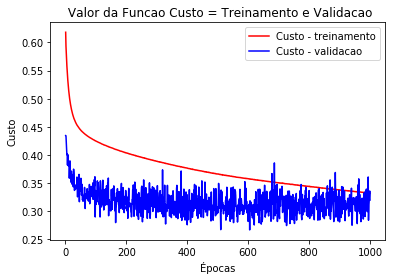

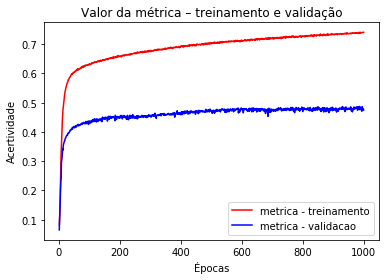

In [18]:
rna0.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[15764  2173]
 [  594  1469]]


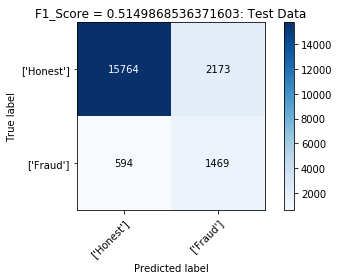

Confusion matrix, without normalization
[[15764  2218]
 [  555  1463]]


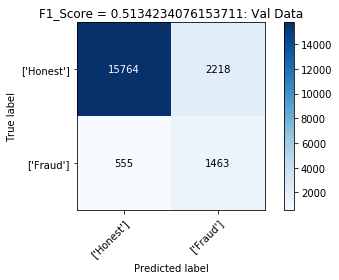

Confusion matrix, without normalization
[[41459  3516]
 [ 5697 14401]]


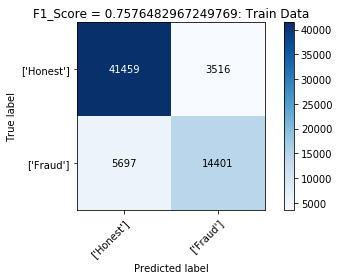

In [19]:
rna0.predict(x_data,y_data)

In [20]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']

In [21]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.6244 - f1: 0.1659 - val_loss: 0.4229 - val_f1: 0.1332
Epoch 2/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.5822 - f1: 0.2147 - val_loss: 0.4400 - val_f1: 0.2126
Epoch 3/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.5627 - f1: 0.2831 - val_loss: 0.3991 - val_f1: 0.2106
Epoch 4/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.5486 - f1: 0.3364 - val_loss: 0.3980 - val_f1: 0.2516
Epoch 5/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.5374 - f1: 0.3785 - val_loss: 0.4008 - val_f1: 0.2963
Epoch 6/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.5281 - f1: 0.4135 - val_loss: 0.3874 - val_f1: 0.3037
Epoch 7/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.5202 - f1: 0.4388 - val_loss: 0.3770 - val_f1

65073/65073 [==============================] - 2s 32us/step - loss: 0.4315 - f1: 0.6214 - val_loss: 0.3297 - val_f1: 0.4336
Epoch 61/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4313 - f1: 0.6190 - val_loss: 0.3369 - val_f1: 0.4330
Epoch 62/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4307 - f1: 0.6237 - val_loss: 0.3189 - val_f1: 0.4317
Epoch 63/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.4301 - f1: 0.6219 - val_loss: 0.3404 - val_f1: 0.4355
Epoch 64/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4296 - f1: 0.6225 - val_loss: 0.3163 - val_f1: 0.4302
Epoch 65/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4289 - f1: 0.6230 - val_loss: 0.3287 - val_f1: 0.4345
Epoch 66/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.4285 - f1: 0.6241 - val_loss: 0.3337 - val_f1: 0.4359
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 32us/step - loss: 0.3923 - f1: 0.6698 - val_loss: 0.2940 - val_f1: 0.4641
Epoch 179/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3921 - f1: 0.6721 - val_loss: 0.3098 - val_f1: 0.4623
Epoch 180/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3918 - f1: 0.6718 - val_loss: 0.3238 - val_f1: 0.4600
Epoch 181/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3917 - f1: 0.6705 - val_loss: 0.3044 - val_f1: 0.4674
Epoch 182/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3912 - f1: 0.6718 - val_loss: 0.3236 - val_f1: 0.4642
Epoch 183/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3911 - f1: 0.6734 - val_loss: 0.3246 - val_f1: 0.4609
Epoch 184/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3908 - f1: 0.6723 - val_loss: 0.3187 - val_f1: 0.4653
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3784 - f1: 0.6870 - val_loss: 0.3087 - val_f1: 0.4719
Epoch 238/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3782 - f1: 0.6866 - val_loss: 0.3221 - val_f1: 0.4654
Epoch 239/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3778 - f1: 0.6871 - val_loss: 0.2939 - val_f1: 0.4755
Epoch 240/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3776 - f1: 0.6879 - val_loss: 0.3046 - val_f1: 0.4724
Epoch 241/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3776 - f1: 0.6883 - val_loss: 0.3404 - val_f1: 0.4582
Epoch 242/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3772 - f1: 0.6885 - val_loss: 0.2992 - val_f1: 0.4736
Epoch 243/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3770 - f1: 0.6899 - val_loss: 0.3000 - val_f1: 0.4751
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3658 - f1: 0.7022 - val_loss: 0.3248 - val_f1: 0.4687
Epoch 297/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3655 - f1: 0.7008 - val_loss: 0.3037 - val_f1: 0.4748
Epoch 298/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3654 - f1: 0.6984 - val_loss: 0.2973 - val_f1: 0.4796
Epoch 299/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3651 - f1: 0.7024 - val_loss: 0.3167 - val_f1: 0.4733
Epoch 300/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3650 - f1: 0.7026 - val_loss: 0.3040 - val_f1: 0.4771
Epoch 301/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3648 - f1: 0.7028 - val_loss: 0.3242 - val_f1: 0.4693
Epoch 302/1000
65073/65073 [==============================] - 2s 32us/step - loss: 0.3644 - f1: 0.7032 - val_loss: 0.3141 - val_f1: 0.4706
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3542 - f1: 0.7158 - val_loss: 0.3119 - val_f1: 0.4759
Epoch 356/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3537 - f1: 0.7166 - val_loss: 0.3191 - val_f1: 0.4739
Epoch 357/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3535 - f1: 0.7157 - val_loss: 0.2977 - val_f1: 0.4838
Epoch 358/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3533 - f1: 0.7183 - val_loss: 0.3110 - val_f1: 0.4784
Epoch 359/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3530 - f1: 0.7181 - val_loss: 0.3255 - val_f1: 0.4757
Epoch 360/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3530 - f1: 0.7189 - val_loss: 0.2926 - val_f1: 0.4840
Epoch 361/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3528 - f1: 0.7154 - val_loss: 0.3157 - val_f1: 0.4774
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 32us/step - loss: 0.3430 - f1: 0.7291 - val_loss: 0.3024 - val_f1: 0.4838
Epoch 415/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3427 - f1: 0.7290 - val_loss: 0.3207 - val_f1: 0.4787
Epoch 416/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3426 - f1: 0.7300 - val_loss: 0.3286 - val_f1: 0.4722
Epoch 417/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3424 - f1: 0.7276 - val_loss: 0.3007 - val_f1: 0.4821
Epoch 418/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3425 - f1: 0.7280 - val_loss: 0.3148 - val_f1: 0.4813
Epoch 419/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3419 - f1: 0.7296 - val_loss: 0.3027 - val_f1: 0.4875
Epoch 420/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3418 - f1: 0.7308 - val_loss: 0.3030 - val_f1: 0.4857
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3331 - f1: 0.7422 - val_loss: 0.3318 - val_f1: 0.4751
Epoch 474/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3328 - f1: 0.7409 - val_loss: 0.3087 - val_f1: 0.4891
Epoch 475/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3325 - f1: 0.7399 - val_loss: 0.3012 - val_f1: 0.4881
Epoch 476/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3323 - f1: 0.7406 - val_loss: 0.2870 - val_f1: 0.4884
Epoch 477/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3322 - f1: 0.7410 - val_loss: 0.3345 - val_f1: 0.4732
Epoch 478/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3322 - f1: 0.7399 - val_loss: 0.3210 - val_f1: 0.4836
Epoch 479/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3318 - f1: 0.7435 - val_loss: 0.3143 - val_f1: 0.4828
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3235 - f1: 0.7506 - val_loss: 0.2988 - val_f1: 0.4903
Epoch 533/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3232 - f1: 0.7507 - val_loss: 0.3318 - val_f1: 0.4779
Epoch 534/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3230 - f1: 0.7527 - val_loss: 0.2890 - val_f1: 0.4942
Epoch 535/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3231 - f1: 0.7506 - val_loss: 0.3003 - val_f1: 0.4916
Epoch 536/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3228 - f1: 0.7507 - val_loss: 0.2994 - val_f1: 0.4912
Epoch 537/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3227 - f1: 0.7529 - val_loss: 0.2776 - val_f1: 0.4919
Epoch 538/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3224 - f1: 0.7509 - val_loss: 0.3177 - val_f1: 0.4831
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3146 - f1: 0.7621 - val_loss: 0.2885 - val_f1: 0.4995
Epoch 592/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.3145 - f1: 0.7577 - val_loss: 0.3046 - val_f1: 0.4935
Epoch 593/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.3142 - f1: 0.7584 - val_loss: 0.3209 - val_f1: 0.4840
Epoch 594/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3140 - f1: 0.7594 - val_loss: 0.2960 - val_f1: 0.4960
Epoch 595/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3139 - f1: 0.7602 - val_loss: 0.3236 - val_f1: 0.4863
Epoch 596/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3138 - f1: 0.7591 - val_loss: 0.3239 - val_f1: 0.4849
Epoch 597/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3136 - f1: 0.7608 - val_loss: 0.3420 - val_f1: 0.4740
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.3059 - f1: 0.7688 - val_loss: 0.2975 - val_f1: 0.5002
Epoch 651/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3060 - f1: 0.7683 - val_loss: 0.3092 - val_f1: 0.4926
Epoch 652/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3056 - f1: 0.7683 - val_loss: 0.3306 - val_f1: 0.4820
Epoch 653/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3052 - f1: 0.7677 - val_loss: 0.3302 - val_f1: 0.4856
Epoch 654/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3052 - f1: 0.7688 - val_loss: 0.3234 - val_f1: 0.4873
Epoch 655/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3051 - f1: 0.7692 - val_loss: 0.3374 - val_f1: 0.4821
Epoch 656/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.3051 - f1: 0.7692 - val_loss: 0.3100 - val_f1: 0.4948
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 34us/step - loss: 0.2979 - f1: 0.7763 - val_loss: 0.3526 - val_f1: 0.4792
Epoch 710/1000
65073/65073 [==============================] - 2s 36us/step - loss: 0.2978 - f1: 0.7757 - val_loss: 0.3065 - val_f1: 0.4975
Epoch 711/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2976 - f1: 0.7766 - val_loss: 0.3216 - val_f1: 0.4970
Epoch 712/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2975 - f1: 0.7757 - val_loss: 0.3172 - val_f1: 0.4923
Epoch 713/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2975 - f1: 0.7768 - val_loss: 0.3181 - val_f1: 0.4905
Epoch 714/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2973 - f1: 0.7764 - val_loss: 0.3035 - val_f1: 0.4957
Epoch 715/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2969 - f1: 0.7746 - val_loss: 0.2938 - val_f1: 0.5005
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 36us/step - loss: 0.2901 - f1: 0.7832 - val_loss: 0.2950 - val_f1: 0.5029
Epoch 769/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2901 - f1: 0.7842 - val_loss: 0.3177 - val_f1: 0.4922
Epoch 770/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2900 - f1: 0.7856 - val_loss: 0.3223 - val_f1: 0.4943
Epoch 771/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2900 - f1: 0.7871 - val_loss: 0.2918 - val_f1: 0.5050
Epoch 772/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2896 - f1: 0.7832 - val_loss: 0.3207 - val_f1: 0.4955
Epoch 773/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2894 - f1: 0.7851 - val_loss: 0.3098 - val_f1: 0.4997
Epoch 774/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2894 - f1: 0.7851 - val_loss: 0.3079 - val_f1: 0.4980
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 36us/step - loss: 0.2828 - f1: 0.7916 - val_loss: 0.3033 - val_f1: 0.5012
Epoch 828/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2827 - f1: 0.7921 - val_loss: 0.3063 - val_f1: 0.5038
Epoch 829/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2828 - f1: 0.7907 - val_loss: 0.3021 - val_f1: 0.5045
Epoch 830/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2826 - f1: 0.7928 - val_loss: 0.2917 - val_f1: 0.5038
Epoch 831/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2823 - f1: 0.7906 - val_loss: 0.3440 - val_f1: 0.4907
Epoch 832/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2821 - f1: 0.7920 - val_loss: 0.3108 - val_f1: 0.4980
Epoch 833/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2823 - f1: 0.7934 - val_loss: 0.3165 - val_f1: 0.4992
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.2757 - f1: 0.7992 - val_loss: 0.3166 - val_f1: 0.5012
Epoch 887/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2758 - f1: 0.7998 - val_loss: 0.3187 - val_f1: 0.5000
Epoch 888/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2755 - f1: 0.8000 - val_loss: 0.2973 - val_f1: 0.5101
Epoch 889/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.2754 - f1: 0.7991 - val_loss: 0.3277 - val_f1: 0.4979
Epoch 890/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2754 - f1: 0.7992 - val_loss: 0.3106 - val_f1: 0.5061
Epoch 891/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2754 - f1: 0.7971 - val_loss: 0.2948 - val_f1: 0.5054
Epoch 892/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.2748 - f1: 0.8018 - val_loss: 0.2877 - val_f1: 0.5061
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 33us/step - loss: 0.2689 - f1: 0.8050 - val_loss: 0.3252 - val_f1: 0.5052
Epoch 946/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2692 - f1: 0.8057 - val_loss: 0.3426 - val_f1: 0.4958
Epoch 947/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2688 - f1: 0.8034 - val_loss: 0.3480 - val_f1: 0.4962
Epoch 948/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2687 - f1: 0.8040 - val_loss: 0.3623 - val_f1: 0.4901
Epoch 949/1000
65073/65073 [==============================] - 2s 33us/step - loss: 0.2686 - f1: 0.8048 - val_loss: 0.3339 - val_f1: 0.5031
Epoch 950/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2686 - f1: 0.8033 - val_loss: 0.3400 - val_f1: 0.4990
Epoch 951/1000
65073/65073 [==============================] - 2s 35us/step - loss: 0.2685 - f1: 0.8058 - val_loss: 0.3123 - val_f1: 0.5051
Epoch 952/1000
65073/65073 [==============

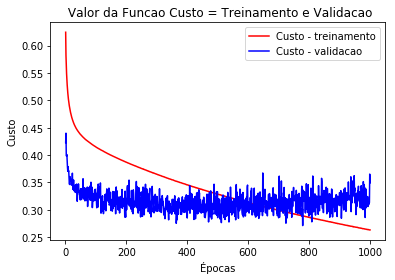

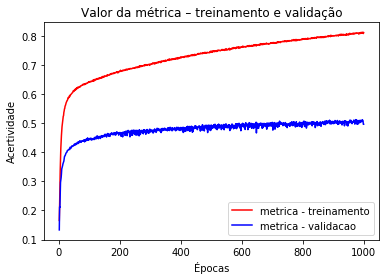

In [22]:
rna1.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[15515  2422]
 [  379  1684]]


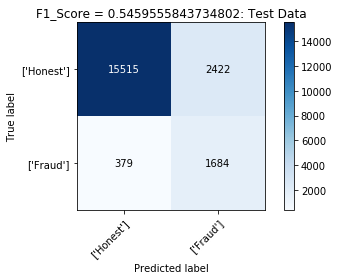

Confusion matrix, without normalization
[[15414  2568]
 [  364  1654]]


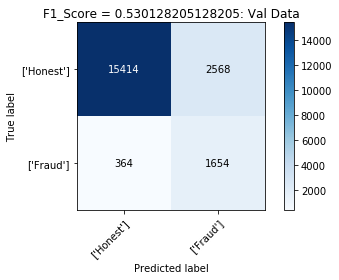

Confusion matrix, without normalization
[[41834  3141]
 [ 3633 16465]]


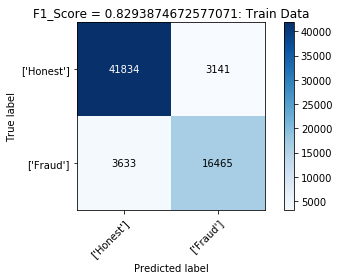

In [23]:
rna1.predict(x_data,y_data)

In [24]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']

In [25]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.6102 - f1: 0.1013 - val_loss: 0.4222 - val_f1: 0.0727
Epoch 2/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5866 - f1: 0.1538 - val_loss: 0.4328 - val_f1: 0.1414
Epoch 3/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5705 - f1: 0.2241 - val_loss: 0.4256 - val_f1: 0.2076
Epoch 4/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5562 - f1: 0.2890 - val_loss: 0.4055 - val_f1: 0.2339
Epoch 5/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5437 - f1: 0.3444 - val_loss: 0.4062 - val_f1: 0.2758
Epoch 6/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.5331 - f1: 0.3861 - val_loss: 0.4001 - val_f1: 0.3037
Epoch 7/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.5238 - f1: 0.4216 - val_loss: 0.4009 - val_f1

65073/65073 [==============================] - 2s 34us/step - loss: 0.4321 - f1: 0.6248 - val_loss: 0.3376 - val_f1: 0.4339
Epoch 61/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4317 - f1: 0.6269 - val_loss: 0.3477 - val_f1: 0.4319
Epoch 62/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4313 - f1: 0.6262 - val_loss: 0.3300 - val_f1: 0.4358
Epoch 63/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4308 - f1: 0.6255 - val_loss: 0.3299 - val_f1: 0.4344
Epoch 64/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4305 - f1: 0.6278 - val_loss: 0.3550 - val_f1: 0.4311
Epoch 65/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4299 - f1: 0.6284 - val_loss: 0.3069 - val_f1: 0.4323
Epoch 66/1000
65073/65073 [==============================] - 2s 34us/step - loss: 0.4297 - f1: 0.6267 - val_loss: 0.3172 - val_f1: 0.4414
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 2s 37us/step - loss: 0.4017 - f1: 0.6631 - val_loss: 0.2951 - val_f1: 0.4394
Epoch 179/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4015 - f1: 0.6616 - val_loss: 0.2945 - val_f1: 0.4377
Epoch 180/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4013 - f1: 0.6635 - val_loss: 0.3341 - val_f1: 0.4499
Epoch 181/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4012 - f1: 0.6646 - val_loss: 0.3241 - val_f1: 0.4489
Epoch 182/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4009 - f1: 0.6623 - val_loss: 0.3158 - val_f1: 0.4512
Epoch 183/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.4009 - f1: 0.6658 - val_loss: 0.2981 - val_f1: 0.4416
Epoch 184/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4006 - f1: 0.6616 - val_loss: 0.3493 - val_f1: 0.4458
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3918 - f1: 0.6724 - val_loss: 0.3135 - val_f1: 0.4539
Epoch 238/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3913 - f1: 0.6749 - val_loss: 0.3134 - val_f1: 0.4520
Epoch 239/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3911 - f1: 0.6744 - val_loss: 0.3272 - val_f1: 0.4500
Epoch 240/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3913 - f1: 0.6743 - val_loss: 0.2945 - val_f1: 0.4525
Epoch 241/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3912 - f1: 0.6742 - val_loss: 0.3777 - val_f1: 0.4354
Epoch 242/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3909 - f1: 0.6752 - val_loss: 0.2891 - val_f1: 0.4470
Epoch 243/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3903 - f1: 0.6741 - val_loss: 0.3118 - val_f1: 0.4555
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3823 - f1: 0.6851 - val_loss: 0.3337 - val_f1: 0.4518
Epoch 297/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3823 - f1: 0.6852 - val_loss: 0.3245 - val_f1: 0.4515
Epoch 298/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3821 - f1: 0.6866 - val_loss: 0.2980 - val_f1: 0.4552
Epoch 299/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3817 - f1: 0.6838 - val_loss: 0.3063 - val_f1: 0.4517
Epoch 300/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3816 - f1: 0.6846 - val_loss: 0.3269 - val_f1: 0.4489
Epoch 301/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3816 - f1: 0.6850 - val_loss: 0.3169 - val_f1: 0.4548
Epoch 302/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3814 - f1: 0.6850 - val_loss: 0.3344 - val_f1: 0.4458
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3737 - f1: 0.6930 - val_loss: 0.2973 - val_f1: 0.4641
Epoch 356/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3730 - f1: 0.6936 - val_loss: 0.3411 - val_f1: 0.4517
Epoch 357/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3733 - f1: 0.6941 - val_loss: 0.3301 - val_f1: 0.4564
Epoch 358/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3731 - f1: 0.6926 - val_loss: 0.3143 - val_f1: 0.4573
Epoch 359/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3729 - f1: 0.6931 - val_loss: 0.3091 - val_f1: 0.4566
Epoch 360/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3728 - f1: 0.6972 - val_loss: 0.3127 - val_f1: 0.4561
Epoch 361/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3727 - f1: 0.6937 - val_loss: 0.2863 - val_f1: 0.4537
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3659 - f1: 0.7032 - val_loss: 0.3334 - val_f1: 0.4611
Epoch 415/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3657 - f1: 0.7029 - val_loss: 0.3092 - val_f1: 0.4625
Epoch 416/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3653 - f1: 0.7019 - val_loss: 0.3220 - val_f1: 0.4624
Epoch 417/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3658 - f1: 0.7028 - val_loss: 0.3153 - val_f1: 0.4636
Epoch 418/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3651 - f1: 0.7041 - val_loss: 0.3704 - val_f1: 0.4434
Epoch 419/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3651 - f1: 0.7026 - val_loss: 0.3058 - val_f1: 0.4666
Epoch 420/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3651 - f1: 0.7037 - val_loss: 0.2874 - val_f1: 0.4608
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3587 - f1: 0.7104 - val_loss: 0.3242 - val_f1: 0.4602
Epoch 474/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3582 - f1: 0.7122 - val_loss: 0.3009 - val_f1: 0.4658
Epoch 475/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3584 - f1: 0.7129 - val_loss: 0.3030 - val_f1: 0.4649
Epoch 476/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3580 - f1: 0.7129 - val_loss: 0.3290 - val_f1: 0.4623
Epoch 477/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3583 - f1: 0.7099 - val_loss: 0.3522 - val_f1: 0.4527
Epoch 478/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3577 - f1: 0.7121 - val_loss: 0.2995 - val_f1: 0.4640
Epoch 479/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3581 - f1: 0.7112 - val_loss: 0.3123 - val_f1: 0.4657
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3519 - f1: 0.7202 - val_loss: 0.3219 - val_f1: 0.4633
Epoch 533/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3516 - f1: 0.7181 - val_loss: 0.3252 - val_f1: 0.4661
Epoch 534/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3518 - f1: 0.7183 - val_loss: 0.3238 - val_f1: 0.4661
Epoch 535/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3514 - f1: 0.7230 - val_loss: 0.3323 - val_f1: 0.4643
Epoch 536/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3515 - f1: 0.7198 - val_loss: 0.2797 - val_f1: 0.4661
Epoch 537/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3514 - f1: 0.7184 - val_loss: 0.3230 - val_f1: 0.4636
Epoch 538/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3514 - f1: 0.7189 - val_loss: 0.3215 - val_f1: 0.4682
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3457 - f1: 0.7264 - val_loss: 0.3246 - val_f1: 0.4680
Epoch 592/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3459 - f1: 0.7254 - val_loss: 0.2856 - val_f1: 0.4690
Epoch 593/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3457 - f1: 0.7261 - val_loss: 0.3593 - val_f1: 0.4618
Epoch 594/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3454 - f1: 0.7242 - val_loss: 0.3088 - val_f1: 0.4714
Epoch 595/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3452 - f1: 0.7243 - val_loss: 0.2996 - val_f1: 0.4699
Epoch 596/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3449 - f1: 0.7280 - val_loss: 0.3205 - val_f1: 0.4671
Epoch 597/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3452 - f1: 0.7243 - val_loss: 0.2806 - val_f1: 0.4700
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3398 - f1: 0.7341 - val_loss: 0.3221 - val_f1: 0.4694
Epoch 651/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3402 - f1: 0.7333 - val_loss: 0.3313 - val_f1: 0.4689
Epoch 652/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3397 - f1: 0.7301 - val_loss: 0.3444 - val_f1: 0.4623
Epoch 653/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3397 - f1: 0.7303 - val_loss: 0.3578 - val_f1: 0.4641
Epoch 654/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3395 - f1: 0.7305 - val_loss: 0.3038 - val_f1: 0.4678
Epoch 655/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3397 - f1: 0.7344 - val_loss: 0.3409 - val_f1: 0.4666
Epoch 656/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3394 - f1: 0.7327 - val_loss: 0.3234 - val_f1: 0.4688
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3350 - f1: 0.7364 - val_loss: 0.3117 - val_f1: 0.4703
Epoch 710/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3350 - f1: 0.7375 - val_loss: 0.3371 - val_f1: 0.4685
Epoch 711/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3350 - f1: 0.7400 - val_loss: 0.3699 - val_f1: 0.4594
Epoch 712/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3346 - f1: 0.7379 - val_loss: 0.3243 - val_f1: 0.4715
Epoch 713/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3344 - f1: 0.7405 - val_loss: 0.2925 - val_f1: 0.4746
Epoch 714/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3343 - f1: 0.7386 - val_loss: 0.3688 - val_f1: 0.4579
Epoch 715/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3344 - f1: 0.7384 - val_loss: 0.3160 - val_f1: 0.4720
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3298 - f1: 0.7417 - val_loss: 0.2959 - val_f1: 0.4744
Epoch 769/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3300 - f1: 0.7439 - val_loss: 0.3401 - val_f1: 0.4679
Epoch 770/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3297 - f1: 0.7417 - val_loss: 0.3342 - val_f1: 0.4670
Epoch 771/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3300 - f1: 0.7423 - val_loss: 0.3082 - val_f1: 0.4715
Epoch 772/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3294 - f1: 0.7428 - val_loss: 0.2901 - val_f1: 0.4702
Epoch 773/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3294 - f1: 0.7443 - val_loss: 0.3221 - val_f1: 0.4724
Epoch 774/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3295 - f1: 0.7421 - val_loss: 0.3352 - val_f1: 0.4682
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3253 - f1: 0.7488 - val_loss: 0.3108 - val_f1: 0.4722
Epoch 828/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3252 - f1: 0.7449 - val_loss: 0.3464 - val_f1: 0.4645
Epoch 829/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3253 - f1: 0.7452 - val_loss: 0.3436 - val_f1: 0.4681
Epoch 830/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3250 - f1: 0.7454 - val_loss: 0.3257 - val_f1: 0.4697
Epoch 831/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3253 - f1: 0.7470 - val_loss: 0.3297 - val_f1: 0.4668
Epoch 832/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3253 - f1: 0.7466 - val_loss: 0.3093 - val_f1: 0.4759
Epoch 833/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3252 - f1: 0.7491 - val_loss: 0.3396 - val_f1: 0.4712
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 38us/step - loss: 0.3211 - f1: 0.7501 - val_loss: 0.3440 - val_f1: 0.4620
Epoch 887/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3208 - f1: 0.7524 - val_loss: 0.3981 - val_f1: 0.4509
Epoch 888/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3210 - f1: 0.7541 - val_loss: 0.3244 - val_f1: 0.4739
Epoch 889/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3216 - f1: 0.7520 - val_loss: 0.3599 - val_f1: 0.4637
Epoch 890/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3209 - f1: 0.7532 - val_loss: 0.3285 - val_f1: 0.4718
Epoch 891/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3207 - f1: 0.7521 - val_loss: 0.3389 - val_f1: 0.4640
Epoch 892/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3204 - f1: 0.7523 - val_loss: 0.3084 - val_f1: 0.4756
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 2s 37us/step - loss: 0.3173 - f1: 0.7569 - val_loss: 0.3533 - val_f1: 0.4682
Epoch 946/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3171 - f1: 0.7555 - val_loss: 0.3131 - val_f1: 0.4726
Epoch 947/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3169 - f1: 0.7567 - val_loss: 0.3166 - val_f1: 0.4765
Epoch 948/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3169 - f1: 0.7549 - val_loss: 0.3095 - val_f1: 0.4717
Epoch 949/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3162 - f1: 0.7550 - val_loss: 0.3519 - val_f1: 0.4670
Epoch 950/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3166 - f1: 0.7573 - val_loss: 0.3168 - val_f1: 0.4780
Epoch 951/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3166 - f1: 0.7568 - val_loss: 0.3574 - val_f1: 0.4657
Epoch 952/1000
65073/65073 [==============

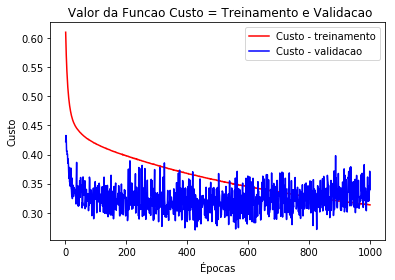

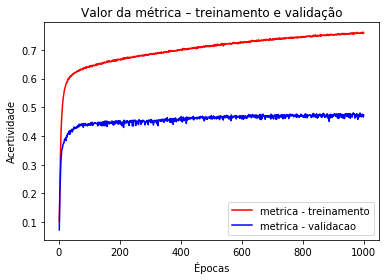

In [26]:
rna2.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[15643  2294]
 [  514  1549]]


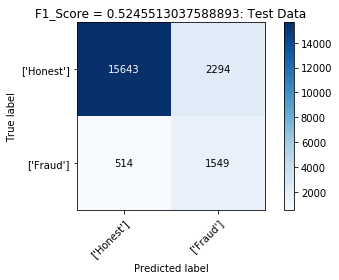

Confusion matrix, without normalization
[[15562  2420]
 [  516  1502]]


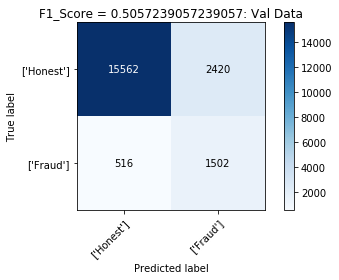

Confusion matrix, without normalization
[[41503  3472]
 [ 5057 15041]]


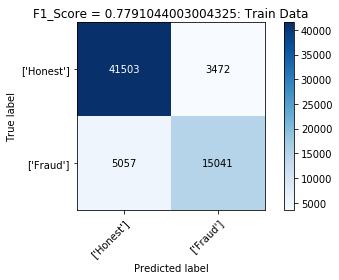

In [27]:
rna2.predict(x_data,y_data)

In [28]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']

In [29]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 55us/step - loss: 0.6145 - f1: 0.1364 - val_loss: 0.4300 - val_f1: 0.1036
Epoch 2/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.5812 - f1: 0.1820 - val_loss: 0.4179 - val_f1: 0.1466
Epoch 3/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.5632 - f1: 0.2484 - val_loss: 0.4226 - val_f1: 0.2323
Epoch 4/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.5493 - f1: 0.3096 - val_loss: 0.3962 - val_f1: 0.2371
Epoch 5/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5377 - f1: 0.3541 - val_loss: 0.3952 - val_f1: 0.2777
Epoch 6/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.5282 - f1: 0.3920 - val_loss: 0.3942 - val_f1: 0.3007
Epoch 7/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.5201 - f1: 0.4228 - val_loss: 0.3798 - val_f1

65073/65073 [==============================] - 3s 40us/step - loss: 0.4311 - f1: 0.6224 - val_loss: 0.3296 - val_f1: 0.4336
Epoch 61/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4305 - f1: 0.6208 - val_loss: 0.3268 - val_f1: 0.4387
Epoch 62/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4302 - f1: 0.6239 - val_loss: 0.3310 - val_f1: 0.4398
Epoch 63/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4295 - f1: 0.6232 - val_loss: 0.3123 - val_f1: 0.4347
Epoch 64/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4290 - f1: 0.6237 - val_loss: 0.3248 - val_f1: 0.4366
Epoch 65/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4282 - f1: 0.6266 - val_loss: 0.3239 - val_f1: 0.4382
Epoch 66/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4280 - f1: 0.6268 - val_loss: 0.3224 - val_f1: 0.4387
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 40us/step - loss: 0.3856 - f1: 0.6792 - val_loss: 0.2978 - val_f1: 0.4639
Epoch 179/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3852 - f1: 0.6836 - val_loss: 0.3189 - val_f1: 0.4664
Epoch 180/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3849 - f1: 0.6841 - val_loss: 0.3053 - val_f1: 0.4653
Epoch 181/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3846 - f1: 0.6841 - val_loss: 0.2929 - val_f1: 0.4661
Epoch 182/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3844 - f1: 0.6843 - val_loss: 0.3043 - val_f1: 0.4669
Epoch 183/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3841 - f1: 0.6835 - val_loss: 0.3061 - val_f1: 0.4677
Epoch 184/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3836 - f1: 0.6841 - val_loss: 0.2975 - val_f1: 0.4645
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3680 - f1: 0.7032 - val_loss: 0.2955 - val_f1: 0.4720
Epoch 238/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3676 - f1: 0.7034 - val_loss: 0.3012 - val_f1: 0.4769
Epoch 239/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3672 - f1: 0.7020 - val_loss: 0.3355 - val_f1: 0.4661
Epoch 240/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3670 - f1: 0.7051 - val_loss: 0.3050 - val_f1: 0.4737
Epoch 241/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3669 - f1: 0.7027 - val_loss: 0.3166 - val_f1: 0.4716
Epoch 242/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3665 - f1: 0.7037 - val_loss: 0.3292 - val_f1: 0.4678
Epoch 243/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3662 - f1: 0.7043 - val_loss: 0.3261 - val_f1: 0.4694
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3517 - f1: 0.7217 - val_loss: 0.3243 - val_f1: 0.4743
Epoch 297/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3513 - f1: 0.7231 - val_loss: 0.2892 - val_f1: 0.4770
Epoch 298/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3511 - f1: 0.7218 - val_loss: 0.3142 - val_f1: 0.4748
Epoch 299/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3509 - f1: 0.7209 - val_loss: 0.3223 - val_f1: 0.4715
Epoch 300/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3508 - f1: 0.7217 - val_loss: 0.3258 - val_f1: 0.4701
Epoch 301/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3505 - f1: 0.7258 - val_loss: 0.3525 - val_f1: 0.4612
Epoch 302/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3502 - f1: 0.7226 - val_loss: 0.3089 - val_f1: 0.4775
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3369 - f1: 0.7396 - val_loss: 0.3620 - val_f1: 0.4594
Epoch 356/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3365 - f1: 0.7358 - val_loss: 0.3232 - val_f1: 0.4727
Epoch 357/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3367 - f1: 0.7357 - val_loss: 0.3406 - val_f1: 0.4698
Epoch 358/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3365 - f1: 0.7368 - val_loss: 0.3019 - val_f1: 0.4794
Epoch 359/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3363 - f1: 0.7392 - val_loss: 0.3191 - val_f1: 0.4759
Epoch 360/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3358 - f1: 0.7383 - val_loss: 0.3010 - val_f1: 0.4820
Epoch 361/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3357 - f1: 0.7391 - val_loss: 0.3006 - val_f1: 0.4814
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 43us/step - loss: 0.3231 - f1: 0.7499 - val_loss: 0.3149 - val_f1: 0.4782
Epoch 415/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3227 - f1: 0.7525 - val_loss: 0.2999 - val_f1: 0.4777
Epoch 416/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3230 - f1: 0.7513 - val_loss: 0.3094 - val_f1: 0.4758
Epoch 417/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3223 - f1: 0.7505 - val_loss: 0.3354 - val_f1: 0.4703
Epoch 418/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3220 - f1: 0.7533 - val_loss: 0.3424 - val_f1: 0.4746
Epoch 419/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3220 - f1: 0.7523 - val_loss: 0.3440 - val_f1: 0.4686
Epoch 420/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3217 - f1: 0.7525 - val_loss: 0.3240 - val_f1: 0.4760
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.3095 - f1: 0.7626 - val_loss: 0.3390 - val_f1: 0.4788
Epoch 474/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3097 - f1: 0.7661 - val_loss: 0.3118 - val_f1: 0.4861
Epoch 475/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3095 - f1: 0.7642 - val_loss: 0.3223 - val_f1: 0.4823
Epoch 476/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3091 - f1: 0.7636 - val_loss: 0.3177 - val_f1: 0.4829
Epoch 477/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3090 - f1: 0.7644 - val_loss: 0.3129 - val_f1: 0.4839
Epoch 478/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3092 - f1: 0.7665 - val_loss: 0.3221 - val_f1: 0.4784
Epoch 479/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3085 - f1: 0.7652 - val_loss: 0.2882 - val_f1: 0.4852
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.2967 - f1: 0.7774 - val_loss: 0.2890 - val_f1: 0.4941
Epoch 533/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2969 - f1: 0.7781 - val_loss: 0.3433 - val_f1: 0.4797
Epoch 534/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2965 - f1: 0.7768 - val_loss: 0.2901 - val_f1: 0.4948
Epoch 535/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2964 - f1: 0.7773 - val_loss: 0.3684 - val_f1: 0.4723
Epoch 536/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2961 - f1: 0.7772 - val_loss: 0.3253 - val_f1: 0.4853
Epoch 537/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2960 - f1: 0.7786 - val_loss: 0.3338 - val_f1: 0.4871
Epoch 538/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2957 - f1: 0.7798 - val_loss: 0.3415 - val_f1: 0.4805
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 43us/step - loss: 0.2844 - f1: 0.7907 - val_loss: 0.2998 - val_f1: 0.4990
Epoch 592/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2843 - f1: 0.7900 - val_loss: 0.3427 - val_f1: 0.4858
Epoch 593/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2841 - f1: 0.7910 - val_loss: 0.3369 - val_f1: 0.4881
Epoch 594/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2841 - f1: 0.7892 - val_loss: 0.3384 - val_f1: 0.4875
Epoch 595/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2838 - f1: 0.7890 - val_loss: 0.3061 - val_f1: 0.4940
Epoch 596/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2838 - f1: 0.7896 - val_loss: 0.3548 - val_f1: 0.4866
Epoch 597/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2837 - f1: 0.7903 - val_loss: 0.3387 - val_f1: 0.4892
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.2733 - f1: 0.8007 - val_loss: 0.3283 - val_f1: 0.4920
Epoch 651/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2727 - f1: 0.8014 - val_loss: 0.3486 - val_f1: 0.4896
Epoch 652/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2727 - f1: 0.7990 - val_loss: 0.3240 - val_f1: 0.4963
Epoch 653/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2723 - f1: 0.8022 - val_loss: 0.3467 - val_f1: 0.4923
Epoch 654/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2728 - f1: 0.8018 - val_loss: 0.3326 - val_f1: 0.4946
Epoch 655/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2719 - f1: 0.8012 - val_loss: 0.3194 - val_f1: 0.4937
Epoch 656/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2721 - f1: 0.8026 - val_loss: 0.3496 - val_f1: 0.4868
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2617 - f1: 0.8115 - val_loss: 0.3718 - val_f1: 0.4862
Epoch 710/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2620 - f1: 0.8098 - val_loss: 0.3078 - val_f1: 0.5047
Epoch 711/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2617 - f1: 0.8116 - val_loss: 0.3536 - val_f1: 0.4930
Epoch 712/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2617 - f1: 0.8083 - val_loss: 0.3217 - val_f1: 0.5009
Epoch 713/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2614 - f1: 0.8123 - val_loss: 0.3618 - val_f1: 0.4916
Epoch 714/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2610 - f1: 0.8115 - val_loss: 0.3335 - val_f1: 0.4958
Epoch 715/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2611 - f1: 0.8101 - val_loss: 0.3234 - val_f1: 0.5013
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.2516 - f1: 0.8202 - val_loss: 0.3358 - val_f1: 0.5014
Epoch 769/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2513 - f1: 0.8201 - val_loss: 0.3785 - val_f1: 0.4913
Epoch 770/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2513 - f1: 0.8217 - val_loss: 0.3355 - val_f1: 0.5037
Epoch 771/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2513 - f1: 0.8177 - val_loss: 0.3579 - val_f1: 0.4982
Epoch 772/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2511 - f1: 0.8193 - val_loss: 0.3542 - val_f1: 0.4976
Epoch 773/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2503 - f1: 0.8187 - val_loss: 0.3686 - val_f1: 0.4940
Epoch 774/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2506 - f1: 0.8188 - val_loss: 0.3954 - val_f1: 0.4896
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.2413 - f1: 0.8298 - val_loss: 0.3706 - val_f1: 0.5007
Epoch 828/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2413 - f1: 0.8288 - val_loss: 0.3536 - val_f1: 0.5047
Epoch 829/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2410 - f1: 0.8301 - val_loss: 0.3444 - val_f1: 0.5068
Epoch 830/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2411 - f1: 0.8298 - val_loss: 0.3370 - val_f1: 0.5082
Epoch 831/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2411 - f1: 0.8305 - val_loss: 0.3478 - val_f1: 0.5032
Epoch 832/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2408 - f1: 0.8300 - val_loss: 0.3528 - val_f1: 0.5047
Epoch 833/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2402 - f1: 0.8329 - val_loss: 0.3688 - val_f1: 0.5045
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.2318 - f1: 0.8374 - val_loss: 0.3757 - val_f1: 0.5098
Epoch 887/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2307 - f1: 0.8399 - val_loss: 0.3850 - val_f1: 0.5043
Epoch 888/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2311 - f1: 0.8381 - val_loss: 0.3452 - val_f1: 0.5085
Epoch 889/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2310 - f1: 0.8389 - val_loss: 0.4169 - val_f1: 0.4962
Epoch 890/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2307 - f1: 0.8395 - val_loss: 0.3431 - val_f1: 0.5093
Epoch 891/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2303 - f1: 0.8392 - val_loss: 0.3640 - val_f1: 0.5118
Epoch 892/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2302 - f1: 0.8377 - val_loss: 0.3553 - val_f1: 0.5120
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.2218 - f1: 0.8447 - val_loss: 0.4111 - val_f1: 0.5011
Epoch 946/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2216 - f1: 0.8469 - val_loss: 0.3800 - val_f1: 0.5108
Epoch 947/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2211 - f1: 0.8467 - val_loss: 0.3791 - val_f1: 0.5141
Epoch 948/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2210 - f1: 0.8457 - val_loss: 0.3323 - val_f1: 0.5160
Epoch 949/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2210 - f1: 0.8460 - val_loss: 0.3552 - val_f1: 0.5112
Epoch 950/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2203 - f1: 0.8483 - val_loss: 0.3939 - val_f1: 0.5113
Epoch 951/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2206 - f1: 0.8474 - val_loss: 0.4283 - val_f1: 0.5001
Epoch 952/1000
65073/65073 [==============

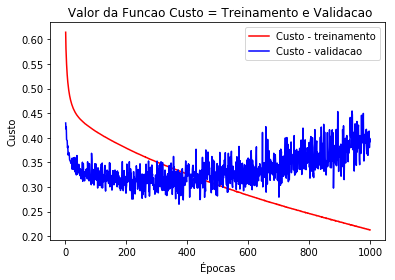

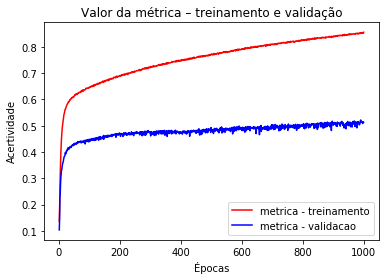

In [30]:
rna3.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[15440  2497]
 [  324  1739]]


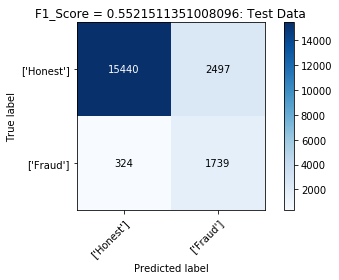

Confusion matrix, without normalization
[[15431  2551]
 [  308  1710]]


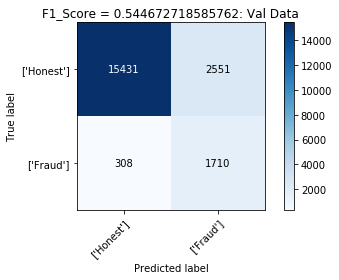

Confusion matrix, without normalization
[[43001  1974]
 [ 3164 16934]]


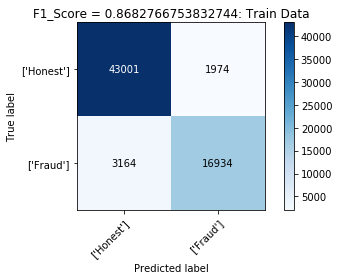

In [31]:
rna3.predict(x_data,y_data)

In [32]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']

In [33]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.6126 - f1: 0.0235 - val_loss: 0.4391 - val_f1: 0.0216
Epoch 2/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.6010 - f1: 0.0326 - val_loss: 0.4303 - val_f1: 0.0388
Epoch 3/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5912 - f1: 0.0698 - val_loss: 0.4277 - val_f1: 0.0821
Epoch 4/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5800 - f1: 0.1425 - val_loss: 0.4257 - val_f1: 0.1461
Epoch 5/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.5694 - f1: 0.2033 - val_loss: 0.4193 - val_f1: 0.1887
Epoch 6/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5589 - f1: 0.2616 - val_loss: 0.4056 - val_f1: 0.2130
Epoch 7/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5486 - f1: 0.3099 - val_loss: 0.4130 - val_f1

65073/65073 [==============================] - 3s 39us/step - loss: 0.4343 - f1: 0.6221 - val_loss: 0.2964 - val_f1: 0.4252
Epoch 61/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4337 - f1: 0.6239 - val_loss: 0.3594 - val_f1: 0.4183
Epoch 62/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4332 - f1: 0.6256 - val_loss: 0.3229 - val_f1: 0.4273
Epoch 63/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4326 - f1: 0.6273 - val_loss: 0.3168 - val_f1: 0.4301
Epoch 64/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.4321 - f1: 0.6281 - val_loss: 0.3150 - val_f1: 0.4305
Epoch 65/1000
65073/65073 [==============================] - 3s 38us/step - loss: 0.4319 - f1: 0.6282 - val_loss: 0.3561 - val_f1: 0.4243
Epoch 66/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4312 - f1: 0.6289 - val_loss: 0.3026 - val_f1: 0.4287
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 39us/step - loss: 0.3986 - f1: 0.6674 - val_loss: 0.3341 - val_f1: 0.4447
Epoch 179/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3983 - f1: 0.6669 - val_loss: 0.2940 - val_f1: 0.4577
Epoch 180/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3982 - f1: 0.6705 - val_loss: 0.2902 - val_f1: 0.4572
Epoch 181/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3979 - f1: 0.6703 - val_loss: 0.3529 - val_f1: 0.4426
Epoch 182/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3979 - f1: 0.6699 - val_loss: 0.3483 - val_f1: 0.4445
Epoch 183/1000
65073/65073 [==============================] - 3s 38us/step - loss: 0.3974 - f1: 0.6717 - val_loss: 0.3546 - val_f1: 0.4427
Epoch 184/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3973 - f1: 0.6725 - val_loss: 0.3195 - val_f1: 0.4569
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 43us/step - loss: 0.3874 - f1: 0.6836 - val_loss: 0.2842 - val_f1: 0.4645
Epoch 238/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3873 - f1: 0.6817 - val_loss: 0.3114 - val_f1: 0.4599
Epoch 239/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3873 - f1: 0.6826 - val_loss: 0.3306 - val_f1: 0.4551
Epoch 240/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3871 - f1: 0.6829 - val_loss: 0.2900 - val_f1: 0.4621
Epoch 241/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3871 - f1: 0.6804 - val_loss: 0.3277 - val_f1: 0.4556
Epoch 242/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3867 - f1: 0.6817 - val_loss: 0.3557 - val_f1: 0.4456
Epoch 243/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3866 - f1: 0.6812 - val_loss: 0.3599 - val_f1: 0.4453
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.3781 - f1: 0.6918 - val_loss: 0.3111 - val_f1: 0.4682
Epoch 297/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3778 - f1: 0.6898 - val_loss: 0.2763 - val_f1: 0.4592
Epoch 298/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3779 - f1: 0.6911 - val_loss: 0.3061 - val_f1: 0.4627
Epoch 299/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3778 - f1: 0.6934 - val_loss: 0.3441 - val_f1: 0.4553
Epoch 300/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3770 - f1: 0.6931 - val_loss: 0.3094 - val_f1: 0.4638
Epoch 301/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3773 - f1: 0.6926 - val_loss: 0.3350 - val_f1: 0.4585
Epoch 302/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3771 - f1: 0.6906 - val_loss: 0.3055 - val_f1: 0.4619
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.3699 - f1: 0.7009 - val_loss: 0.2954 - val_f1: 0.4732
Epoch 356/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3698 - f1: 0.7023 - val_loss: 0.3217 - val_f1: 0.4652
Epoch 357/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3698 - f1: 0.6999 - val_loss: 0.2777 - val_f1: 0.4660
Epoch 358/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3693 - f1: 0.7040 - val_loss: 0.2947 - val_f1: 0.4677
Epoch 359/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3693 - f1: 0.7016 - val_loss: 0.3261 - val_f1: 0.4671
Epoch 360/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3693 - f1: 0.7020 - val_loss: 0.3253 - val_f1: 0.4624
Epoch 361/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3690 - f1: 0.7020 - val_loss: 0.2842 - val_f1: 0.4668
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.3618 - f1: 0.7091 - val_loss: 0.3103 - val_f1: 0.4699
Epoch 415/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3622 - f1: 0.7108 - val_loss: 0.3004 - val_f1: 0.4677
Epoch 416/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3619 - f1: 0.7102 - val_loss: 0.3236 - val_f1: 0.4669
Epoch 417/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3620 - f1: 0.7110 - val_loss: 0.3183 - val_f1: 0.4680
Epoch 418/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3620 - f1: 0.7084 - val_loss: 0.3495 - val_f1: 0.4595
Epoch 419/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3619 - f1: 0.7094 - val_loss: 0.3849 - val_f1: 0.4444
Epoch 420/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3617 - f1: 0.7122 - val_loss: 0.2789 - val_f1: 0.4643
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.3549 - f1: 0.7200 - val_loss: 0.3226 - val_f1: 0.4666
Epoch 474/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3555 - f1: 0.7162 - val_loss: 0.3510 - val_f1: 0.4631
Epoch 475/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3552 - f1: 0.7167 - val_loss: 0.2784 - val_f1: 0.4744
Epoch 476/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3552 - f1: 0.7173 - val_loss: 0.3126 - val_f1: 0.4719
Epoch 477/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3549 - f1: 0.7169 - val_loss: 0.3189 - val_f1: 0.4691
Epoch 478/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3549 - f1: 0.7176 - val_loss: 0.3275 - val_f1: 0.4674
Epoch 479/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3546 - f1: 0.7177 - val_loss: 0.3503 - val_f1: 0.4616
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3488 - f1: 0.7269 - val_loss: 0.3558 - val_f1: 0.4632
Epoch 533/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3490 - f1: 0.7237 - val_loss: 0.2993 - val_f1: 0.4744
Epoch 534/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.3488 - f1: 0.7252 - val_loss: 0.3258 - val_f1: 0.4694
Epoch 535/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3492 - f1: 0.7259 - val_loss: 0.3154 - val_f1: 0.4756
Epoch 536/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3485 - f1: 0.7264 - val_loss: 0.3129 - val_f1: 0.4685
Epoch 537/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3485 - f1: 0.7249 - val_loss: 0.3369 - val_f1: 0.4697
Epoch 538/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3485 - f1: 0.7275 - val_loss: 0.3071 - val_f1: 0.4706
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3432 - f1: 0.7332 - val_loss: 0.3390 - val_f1: 0.4741
Epoch 592/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3433 - f1: 0.7288 - val_loss: 0.3051 - val_f1: 0.4752
Epoch 593/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3431 - f1: 0.7321 - val_loss: 0.3389 - val_f1: 0.4707
Epoch 594/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3433 - f1: 0.7341 - val_loss: 0.3214 - val_f1: 0.4761
Epoch 595/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3428 - f1: 0.7311 - val_loss: 0.3335 - val_f1: 0.4735
Epoch 596/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3428 - f1: 0.7311 - val_loss: 0.3636 - val_f1: 0.4605
Epoch 597/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3428 - f1: 0.7334 - val_loss: 0.3250 - val_f1: 0.4719
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.3381 - f1: 0.7355 - val_loss: 0.3458 - val_f1: 0.4691
Epoch 651/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3379 - f1: 0.7355 - val_loss: 0.3498 - val_f1: 0.4656
Epoch 652/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3373 - f1: 0.7368 - val_loss: 0.2951 - val_f1: 0.4799
Epoch 653/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.3372 - f1: 0.7385 - val_loss: 0.3038 - val_f1: 0.4734
Epoch 654/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3371 - f1: 0.7364 - val_loss: 0.3249 - val_f1: 0.4705
Epoch 655/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3374 - f1: 0.7374 - val_loss: 0.3147 - val_f1: 0.4780
Epoch 656/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3375 - f1: 0.7373 - val_loss: 0.3448 - val_f1: 0.4703
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3326 - f1: 0.7439 - val_loss: 0.3290 - val_f1: 0.4738
Epoch 710/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3325 - f1: 0.7417 - val_loss: 0.3286 - val_f1: 0.4733
Epoch 711/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3321 - f1: 0.7434 - val_loss: 0.3427 - val_f1: 0.4676
Epoch 712/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3320 - f1: 0.7426 - val_loss: 0.3075 - val_f1: 0.4766
Epoch 713/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3316 - f1: 0.7460 - val_loss: 0.3390 - val_f1: 0.4686
Epoch 714/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3319 - f1: 0.7431 - val_loss: 0.3730 - val_f1: 0.4611
Epoch 715/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3318 - f1: 0.7436 - val_loss: 0.3373 - val_f1: 0.4702
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3276 - f1: 0.7473 - val_loss: 0.2901 - val_f1: 0.4782
Epoch 769/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3276 - f1: 0.7508 - val_loss: 0.3193 - val_f1: 0.4784
Epoch 770/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3271 - f1: 0.7495 - val_loss: 0.3247 - val_f1: 0.4761
Epoch 771/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3271 - f1: 0.7499 - val_loss: 0.3310 - val_f1: 0.4736
Epoch 772/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3268 - f1: 0.7491 - val_loss: 0.3124 - val_f1: 0.4780
Epoch 773/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3270 - f1: 0.7478 - val_loss: 0.2942 - val_f1: 0.4734
Epoch 774/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3268 - f1: 0.7467 - val_loss: 0.3450 - val_f1: 0.4717
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 49us/step - loss: 0.3230 - f1: 0.7553 - val_loss: 0.3355 - val_f1: 0.4736
Epoch 828/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.3225 - f1: 0.7537 - val_loss: 0.3218 - val_f1: 0.4773
Epoch 829/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.3227 - f1: 0.7541 - val_loss: 0.2981 - val_f1: 0.4781
Epoch 830/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3224 - f1: 0.7543 - val_loss: 0.3661 - val_f1: 0.4691
Epoch 831/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.3221 - f1: 0.7534 - val_loss: 0.3468 - val_f1: 0.4723
Epoch 832/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.3224 - f1: 0.7529 - val_loss: 0.3511 - val_f1: 0.4733
Epoch 833/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.3224 - f1: 0.7536 - val_loss: 0.3347 - val_f1: 0.4765
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3181 - f1: 0.7617 - val_loss: 0.3899 - val_f1: 0.4586
Epoch 887/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3183 - f1: 0.7605 - val_loss: 0.3506 - val_f1: 0.4785
Epoch 888/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3185 - f1: 0.7581 - val_loss: 0.3772 - val_f1: 0.4629
Epoch 889/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3182 - f1: 0.7592 - val_loss: 0.3497 - val_f1: 0.4749
Epoch 890/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.3177 - f1: 0.7580 - val_loss: 0.3128 - val_f1: 0.4837
Epoch 891/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3177 - f1: 0.7599 - val_loss: 0.3118 - val_f1: 0.4827
Epoch 892/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.3176 - f1: 0.7594 - val_loss: 0.3523 - val_f1: 0.4750
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 39us/step - loss: 0.3143 - f1: 0.7636 - val_loss: 0.3619 - val_f1: 0.4715
Epoch 946/1000
65073/65073 [==============================] - 2s 37us/step - loss: 0.3142 - f1: 0.7636 - val_loss: 0.3984 - val_f1: 0.4621
Epoch 947/1000
65073/65073 [==============================] - 3s 39us/step - loss: 0.3139 - f1: 0.7653 - val_loss: 0.3447 - val_f1: 0.4772
Epoch 948/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3138 - f1: 0.7632 - val_loss: 0.3289 - val_f1: 0.4809
Epoch 949/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.3137 - f1: 0.7623 - val_loss: 0.3665 - val_f1: 0.4735
Epoch 950/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.3139 - f1: 0.7630 - val_loss: 0.3573 - val_f1: 0.4726
Epoch 951/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3136 - f1: 0.7628 - val_loss: 0.3683 - val_f1: 0.4724
Epoch 952/1000
65073/65073 [==============

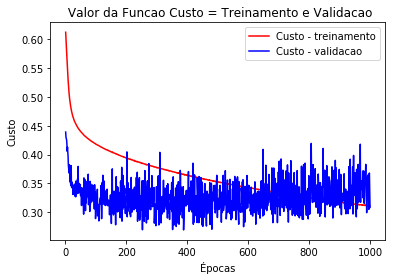

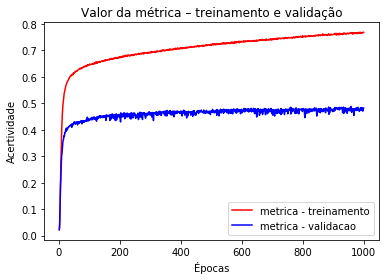

In [34]:
rna4.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[15985  1952]
 [  639  1424]]


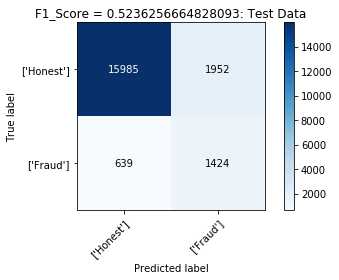

Confusion matrix, without normalization
[[15924  2058]
 [  560  1458]]


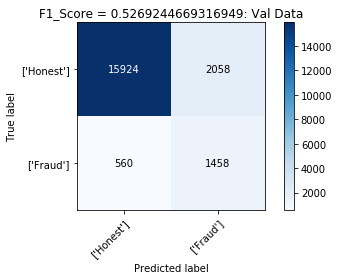

Confusion matrix, without normalization
[[42469  2506]
 [ 5974 14124]]


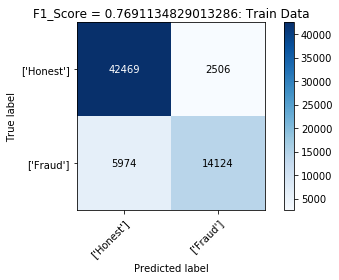

In [35]:
rna4.predict(x_data,y_data)

In [36]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']

In [37]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.6196 - f1: 0.0410 - val_loss: 0.4462 - val_f1: 0.0353
Epoch 2/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5968 - f1: 0.0550 - val_loss: 0.4284 - val_f1: 0.0564
Epoch 3/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.5840 - f1: 0.0963 - val_loss: 0.4157 - val_f1: 0.0786
Epoch 4/1000
65073/65073 [==============================] - 3s 38us/step - loss: 0.5729 - f1: 0.1500 - val_loss: 0.4192 - val_f1: 0.1433
Epoch 5/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.5623 - f1: 0.2093 - val_loss: 0.4130 - val_f1: 0.1859
Epoch 6/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4428 - f1: 0.6108 - val_loss: 0.3244 - val_f1: 0.4171
Epoch 45/1000
65073/65073 [==============================] - 2s 38us/step - loss: 0.4423 - f1: 0.6088 - val_loss: 0.3339 - val_f

65073/65073 [==============================] - 3s 40us/step - loss: 0.4127 - f1: 0.6494 - val_loss: 0.3353 - val_f1: 0.4359
Epoch 99/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4124 - f1: 0.6479 - val_loss: 0.3289 - val_f1: 0.4361
Epoch 100/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4122 - f1: 0.6480 - val_loss: 0.3455 - val_f1: 0.4342
Epoch 101/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4113 - f1: 0.6498 - val_loss: 0.3236 - val_f1: 0.4383
Epoch 102/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4111 - f1: 0.6497 - val_loss: 0.3329 - val_f1: 0.4379
Epoch 103/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4105 - f1: 0.6516 - val_loss: 0.3280 - val_f1: 0.4404
Epoch 104/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.4104 - f1: 0.6504 - val_loss: 0.3342 - val_f1: 0.4357
Epoch 105/1000
65073/65073 [===============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3893 - f1: 0.6762 - val_loss: 0.3195 - val_f1: 0.4519
Epoch 158/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3888 - f1: 0.6768 - val_loss: 0.3169 - val_f1: 0.4482
Epoch 159/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.3884 - f1: 0.6782 - val_loss: 0.3146 - val_f1: 0.4501
Epoch 160/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3883 - f1: 0.6785 - val_loss: 0.3107 - val_f1: 0.4493
Epoch 161/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3879 - f1: 0.6767 - val_loss: 0.3343 - val_f1: 0.4423
Epoch 162/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3873 - f1: 0.6799 - val_loss: 0.3281 - val_f1: 0.4483
Epoch 163/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3870 - f1: 0.6796 - val_loss: 0.3396 - val_f1: 0.4418
Epoch 164/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 40us/step - loss: 0.3692 - f1: 0.7017 - val_loss: 0.3138 - val_f1: 0.4583
Epoch 217/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3688 - f1: 0.7022 - val_loss: 0.2933 - val_f1: 0.4620
Epoch 218/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3685 - f1: 0.7033 - val_loss: 0.3099 - val_f1: 0.4531
Epoch 219/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.3680 - f1: 0.7024 - val_loss: 0.3119 - val_f1: 0.4581
Epoch 220/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3676 - f1: 0.7040 - val_loss: 0.3209 - val_f1: 0.4535
Epoch 221/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3672 - f1: 0.7050 - val_loss: 0.3040 - val_f1: 0.4593
Epoch 222/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3670 - f1: 0.7034 - val_loss: 0.3415 - val_f1: 0.4470
Epoch 223/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3506 - f1: 0.7217 - val_loss: 0.3264 - val_f1: 0.4668
Epoch 276/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3507 - f1: 0.7236 - val_loss: 0.3317 - val_f1: 0.4622
Epoch 277/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.3498 - f1: 0.7247 - val_loss: 0.3661 - val_f1: 0.4487
Epoch 278/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3497 - f1: 0.7246 - val_loss: 0.3328 - val_f1: 0.4625
Epoch 279/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3493 - f1: 0.7235 - val_loss: 0.3096 - val_f1: 0.4717
Epoch 280/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3498 - f1: 0.7250 - val_loss: 0.3345 - val_f1: 0.4609
Epoch 281/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3487 - f1: 0.7242 - val_loss: 0.3690 - val_f1: 0.4513
Epoch 282/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3336 - f1: 0.7444 - val_loss: 0.3486 - val_f1: 0.4672
Epoch 335/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3334 - f1: 0.7422 - val_loss: 0.3216 - val_f1: 0.4801
Epoch 336/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3332 - f1: 0.7413 - val_loss: 0.3433 - val_f1: 0.4683
Epoch 337/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3328 - f1: 0.7407 - val_loss: 0.3494 - val_f1: 0.4686
Epoch 338/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3325 - f1: 0.7419 - val_loss: 0.3173 - val_f1: 0.4812
Epoch 339/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3323 - f1: 0.7420 - val_loss: 0.3291 - val_f1: 0.4720
Epoch 340/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3321 - f1: 0.7436 - val_loss: 0.3545 - val_f1: 0.4661
Epoch 341/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.3170 - f1: 0.7604 - val_loss: 0.3096 - val_f1: 0.4842
Epoch 394/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3171 - f1: 0.7574 - val_loss: 0.3412 - val_f1: 0.4789
Epoch 395/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.3170 - f1: 0.7594 - val_loss: 0.3413 - val_f1: 0.4750
Epoch 396/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3167 - f1: 0.7573 - val_loss: 0.3752 - val_f1: 0.4646
Epoch 397/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.3166 - f1: 0.7583 - val_loss: 0.3120 - val_f1: 0.4859
Epoch 398/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3159 - f1: 0.7596 - val_loss: 0.3144 - val_f1: 0.4863
Epoch 399/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3158 - f1: 0.7582 - val_loss: 0.3336 - val_f1: 0.4842
Epoch 400/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.3016 - f1: 0.7723 - val_loss: 0.3768 - val_f1: 0.4695
Epoch 453/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3022 - f1: 0.7737 - val_loss: 0.3221 - val_f1: 0.4925
Epoch 454/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3012 - f1: 0.7725 - val_loss: 0.2878 - val_f1: 0.4935
Epoch 455/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.3012 - f1: 0.7723 - val_loss: 0.3648 - val_f1: 0.4738
Epoch 456/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3011 - f1: 0.7722 - val_loss: 0.3204 - val_f1: 0.4927
Epoch 457/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3008 - f1: 0.7737 - val_loss: 0.3438 - val_f1: 0.4812
Epoch 458/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.3007 - f1: 0.7737 - val_loss: 0.2978 - val_f1: 0.4910
Epoch 459/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2870 - f1: 0.7875 - val_loss: 0.3163 - val_f1: 0.4984
Epoch 512/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2869 - f1: 0.7861 - val_loss: 0.3535 - val_f1: 0.4872
Epoch 513/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2866 - f1: 0.7879 - val_loss: 0.3012 - val_f1: 0.4999
Epoch 514/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2867 - f1: 0.7875 - val_loss: 0.3097 - val_f1: 0.4999
Epoch 515/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2860 - f1: 0.7885 - val_loss: 0.3463 - val_f1: 0.4883
Epoch 516/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.2859 - f1: 0.7883 - val_loss: 0.3558 - val_f1: 0.4863
Epoch 517/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.2858 - f1: 0.7889 - val_loss: 0.3367 - val_f1: 0.4921
Epoch 518/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2721 - f1: 0.8006 - val_loss: 0.3587 - val_f1: 0.4891
Epoch 571/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2723 - f1: 0.8005 - val_loss: 0.2858 - val_f1: 0.5023
Epoch 572/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2714 - f1: 0.7992 - val_loss: 0.3169 - val_f1: 0.5003
Epoch 573/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2719 - f1: 0.7990 - val_loss: 0.3218 - val_f1: 0.5021
Epoch 574/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2713 - f1: 0.8040 - val_loss: 0.3059 - val_f1: 0.5035
Epoch 575/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2710 - f1: 0.8013 - val_loss: 0.3446 - val_f1: 0.4955
Epoch 576/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2707 - f1: 0.8005 - val_loss: 0.3883 - val_f1: 0.4827
Epoch 577/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.2581 - f1: 0.8124 - val_loss: 0.3480 - val_f1: 0.4997
Epoch 630/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2574 - f1: 0.8152 - val_loss: 0.3439 - val_f1: 0.5030
Epoch 631/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2571 - f1: 0.8150 - val_loss: 0.3306 - val_f1: 0.5047
Epoch 632/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2570 - f1: 0.8154 - val_loss: 0.3414 - val_f1: 0.5019
Epoch 633/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2567 - f1: 0.8156 - val_loss: 0.3725 - val_f1: 0.4919
Epoch 634/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2567 - f1: 0.8163 - val_loss: 0.3536 - val_f1: 0.4969
Epoch 635/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2558 - f1: 0.8176 - val_loss: 0.3546 - val_f1: 0.4995
Epoch 636/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2436 - f1: 0.8267 - val_loss: 0.3550 - val_f1: 0.5024
Epoch 689/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2433 - f1: 0.8273 - val_loss: 0.3656 - val_f1: 0.5020
Epoch 690/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2426 - f1: 0.8294 - val_loss: 0.3376 - val_f1: 0.5040
Epoch 691/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2422 - f1: 0.8291 - val_loss: 0.3572 - val_f1: 0.5059
Epoch 692/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2426 - f1: 0.8268 - val_loss: 0.3585 - val_f1: 0.5027
Epoch 693/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2420 - f1: 0.8262 - val_loss: 0.3361 - val_f1: 0.5121
Epoch 694/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2423 - f1: 0.8273 - val_loss: 0.3482 - val_f1: 0.5059
Epoch 695/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2293 - f1: 0.8395 - val_loss: 0.3726 - val_f1: 0.5120
Epoch 748/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2293 - f1: 0.8381 - val_loss: 0.4220 - val_f1: 0.4977
Epoch 749/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2290 - f1: 0.8417 - val_loss: 0.3684 - val_f1: 0.5124
Epoch 750/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2283 - f1: 0.8401 - val_loss: 0.3972 - val_f1: 0.5058
Epoch 751/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2290 - f1: 0.8391 - val_loss: 0.3816 - val_f1: 0.5071
Epoch 752/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2277 - f1: 0.8418 - val_loss: 0.3784 - val_f1: 0.5120
Epoch 753/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2278 - f1: 0.8407 - val_loss: 0.3646 - val_f1: 0.5148
Epoch 754/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.2151 - f1: 0.8527 - val_loss: 0.3775 - val_f1: 0.5167
Epoch 807/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2154 - f1: 0.8526 - val_loss: 0.3958 - val_f1: 0.5178
Epoch 808/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2151 - f1: 0.8536 - val_loss: 0.4184 - val_f1: 0.5092
Epoch 809/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2149 - f1: 0.8528 - val_loss: 0.4199 - val_f1: 0.5080
Epoch 810/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.2148 - f1: 0.8522 - val_loss: 0.4040 - val_f1: 0.5108
Epoch 811/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2146 - f1: 0.8512 - val_loss: 0.3688 - val_f1: 0.5206
Epoch 812/1000
65073/65073 [==============================] - 3s 40us/step - loss: 0.2140 - f1: 0.8539 - val_loss: 0.3585 - val_f1: 0.5225
Epoch 813/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.2020 - f1: 0.8632 - val_loss: 0.3741 - val_f1: 0.5255
Epoch 866/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.2016 - f1: 0.8639 - val_loss: 0.4380 - val_f1: 0.5107
Epoch 867/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2014 - f1: 0.8642 - val_loss: 0.3648 - val_f1: 0.5238
Epoch 868/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.2015 - f1: 0.8626 - val_loss: 0.4214 - val_f1: 0.5156
Epoch 869/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2014 - f1: 0.8636 - val_loss: 0.4303 - val_f1: 0.5126
Epoch 870/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.2009 - f1: 0.8638 - val_loss: 0.4089 - val_f1: 0.5227
Epoch 871/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.2005 - f1: 0.8652 - val_loss: 0.4172 - val_f1: 0.5202
Epoch 872/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.1897 - f1: 0.8742 - val_loss: 0.4564 - val_f1: 0.5178
Epoch 925/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1892 - f1: 0.8744 - val_loss: 0.4143 - val_f1: 0.5245
Epoch 926/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1888 - f1: 0.8748 - val_loss: 0.4107 - val_f1: 0.5242
Epoch 927/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.1888 - f1: 0.8727 - val_loss: 0.4652 - val_f1: 0.5093
Epoch 928/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1885 - f1: 0.8713 - val_loss: 0.4099 - val_f1: 0.5310
Epoch 929/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.1883 - f1: 0.8739 - val_loss: 0.4234 - val_f1: 0.5255
Epoch 930/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1880 - f1: 0.8747 - val_loss: 0.3950 - val_f1: 0.5309
Epoch 931/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.1768 - f1: 0.8827 - val_loss: 0.4080 - val_f1: 0.5272
Epoch 984/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1762 - f1: 0.8847 - val_loss: 0.4335 - val_f1: 0.5244
Epoch 985/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.1760 - f1: 0.8820 - val_loss: 0.4549 - val_f1: 0.5237
Epoch 986/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.1760 - f1: 0.8831 - val_loss: 0.4518 - val_f1: 0.5229
Epoch 987/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.1760 - f1: 0.8839 - val_loss: 0.4436 - val_f1: 0.5240
Epoch 988/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1758 - f1: 0.8839 - val_loss: 0.5182 - val_f1: 0.5024
Epoch 989/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.1754 - f1: 0.8833 - val_loss: 0.4804 - val_f1: 0.5203
Epoch 990/1000
65073/65073 [==============

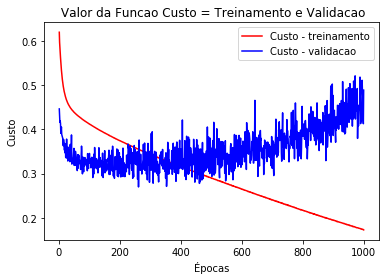

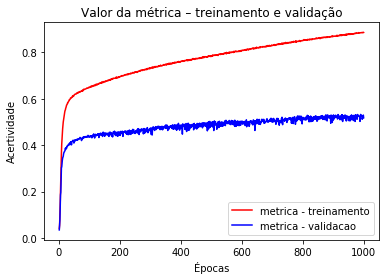

In [38]:
rna5.train(x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[15131  2806]
 [  216  1847]]


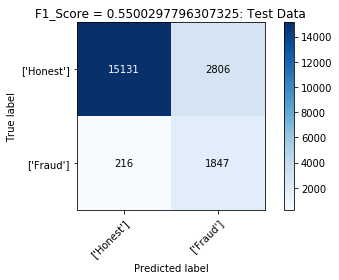

Confusion matrix, without normalization
[[15164  2818]
 [  197  1821]]


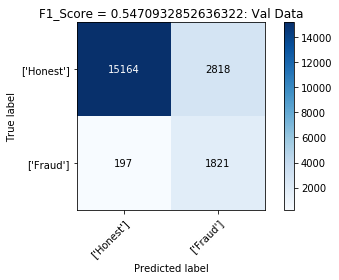

Confusion matrix, without normalization
[[42842  2133]
 [ 2007 18091]]


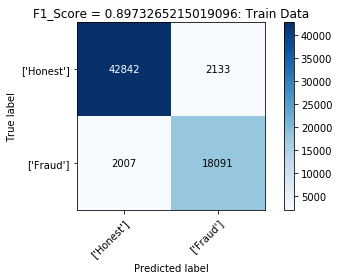

In [39]:
rna5.predict(x_data,y_data)

### Agora iremos utilizar a tecnica de regularizacao chamada dropout. Essa tecnica eh utilizada para combater o overffiting (diferenca consideravel entre a acertividade do modelo com os dados de treinamento e validacao/teste), nessa tecnica os neuronios sao "desligados" ao longo das epocas, para que os pesos da rede se ajustem de forma mais igualitaria.


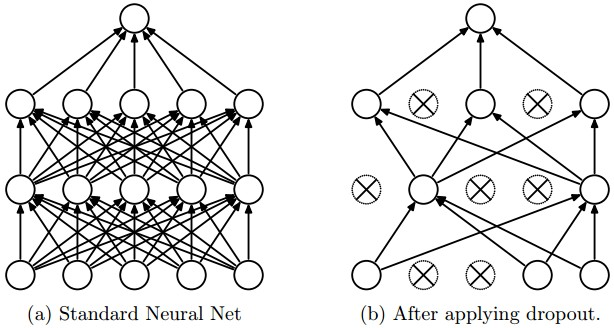


In [17]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [18]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
class new_rna_droplist:
    def build_model(self,data_shape,units_list,activation_list,dropout_list):
        self.model = models.Sequential()
        if len(dropout_list)==0:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        else:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                                input_shape=data_shape,kernel_regularizer = regularizers.l2(0.01)))
                elif i < (len(units_list)-1):
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i],
                                               kernel_regularizer = regularizers.l2(0.01)))
                else:
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.000005, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [20]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 25
epochs = 1000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [60]:
n_list6 = [50,1]
activation_list6 = ['tanh','sigmoid']
dropout_list6 = [0.2]

In [61]:
rna6 = new_rna_droplist()
rna6.build_model(data_shape,n_list6,activation_list6,dropout_list6)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 4s 56us/step - loss: 0.8261 - f1: 0.3345 - val_loss: 0.7840 - val_f1: 0.1542
Epoch 2/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.7871 - f1: 0.3641 - val_loss: 0.7417 - val_f1: 0.1787
Epoch 3/1000
65073/65073 [==============================] - 4s 57us/step - loss: 0.7560 - f1: 0.3883 - val_loss: 0.7053 - val_f1: 0.2083
Epoch 4/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.7265 - f1: 0.4225 - val_loss: 0.6737 - val_f1: 0.2398
Epoch 5/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.7025 - f1: 0.4537 - val_loss: 0.6463 - val_f1: 0.2699
Epoch 6/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.6814 - f1: 0.4812 - val_loss: 0.6223 - val_f1: 0.2973
Epoch 7/1000
65073/65073 [==============================] - 3s 52us/step - loss:

65073/65073 [==============================] - 3s 45us/step - loss: 0.4697 - f1: 0.6393 - val_loss: 0.3613 - val_f1: 0.4457
Epoch 118/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4683 - f1: 0.6393 - val_loss: 0.3610 - val_f1: 0.4458
Epoch 119/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4686 - f1: 0.6400 - val_loss: 0.3608 - val_f1: 0.4461
Epoch 120/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4682 - f1: 0.6378 - val_loss: 0.3605 - val_f1: 0.4457
Epoch 121/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4677 - f1: 0.6401 - val_loss: 0.3603 - val_f1: 0.4461
Epoch 122/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4678 - f1: 0.6390 - val_loss: 0.3600 - val_f1: 0.4460
Epoch 123/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4675 - f1: 0.6432 - val_loss: 0.3597 - val_f1: 0.4457
Epoch 124/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4560 - f1: 0.6404 - val_loss: 0.3486 - val_f1: 0.4455
Epoch 177/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4560 - f1: 0.6427 - val_loss: 0.3484 - val_f1: 0.4456
Epoch 178/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4562 - f1: 0.6415 - val_loss: 0.3483 - val_f1: 0.4456
Epoch 179/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4552 - f1: 0.6410 - val_loss: 0.3481 - val_f1: 0.4457
Epoch 180/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4551 - f1: 0.6427 - val_loss: 0.3479 - val_f1: 0.4462
Epoch 181/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4554 - f1: 0.6426 - val_loss: 0.3478 - val_f1: 0.4462
Epoch 182/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4552 - f1: 0.6402 - val_loss: 0.3476 - val_f1: 0.4460
Epoch 183/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4470 - f1: 0.6415 - val_loss: 0.3400 - val_f1: 0.4455
Epoch 236/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4465 - f1: 0.6407 - val_loss: 0.3399 - val_f1: 0.4455
Epoch 237/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4463 - f1: 0.6425 - val_loss: 0.3398 - val_f1: 0.4455
Epoch 238/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4459 - f1: 0.6418 - val_loss: 0.3396 - val_f1: 0.4457
Epoch 239/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4464 - f1: 0.6404 - val_loss: 0.3395 - val_f1: 0.4453
Epoch 240/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4458 - f1: 0.6421 - val_loss: 0.3394 - val_f1: 0.4452
Epoch 241/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4454 - f1: 0.6419 - val_loss: 0.3393 - val_f1: 0.4451
Epoch 242/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4398 - f1: 0.6411 - val_loss: 0.3340 - val_f1: 0.4458
Epoch 295/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4401 - f1: 0.6419 - val_loss: 0.3339 - val_f1: 0.4458
Epoch 296/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4394 - f1: 0.6425 - val_loss: 0.3338 - val_f1: 0.4458
Epoch 297/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4396 - f1: 0.6410 - val_loss: 0.3337 - val_f1: 0.4454
Epoch 298/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4392 - f1: 0.6437 - val_loss: 0.3336 - val_f1: 0.4452
Epoch 299/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4393 - f1: 0.6419 - val_loss: 0.3335 - val_f1: 0.4453
Epoch 300/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4392 - f1: 0.6431 - val_loss: 0.3334 - val_f1: 0.4456
Epoch 301/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4349 - f1: 0.6444 - val_loss: 0.3296 - val_f1: 0.4453
Epoch 354/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4346 - f1: 0.6440 - val_loss: 0.3295 - val_f1: 0.4455
Epoch 355/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4345 - f1: 0.6414 - val_loss: 0.3295 - val_f1: 0.4454
Epoch 356/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4344 - f1: 0.6439 - val_loss: 0.3294 - val_f1: 0.4455
Epoch 357/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4345 - f1: 0.6431 - val_loss: 0.3293 - val_f1: 0.4455
Epoch 358/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4344 - f1: 0.6445 - val_loss: 0.3292 - val_f1: 0.4459
Epoch 359/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4340 - f1: 0.6417 - val_loss: 0.3292 - val_f1: 0.4460
Epoch 360/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4311 - f1: 0.6460 - val_loss: 0.3264 - val_f1: 0.4451
Epoch 413/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4310 - f1: 0.6425 - val_loss: 0.3263 - val_f1: 0.4452
Epoch 414/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4313 - f1: 0.6430 - val_loss: 0.3263 - val_f1: 0.4449
Epoch 415/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4311 - f1: 0.6446 - val_loss: 0.3263 - val_f1: 0.4449
Epoch 416/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4312 - f1: 0.6414 - val_loss: 0.3262 - val_f1: 0.4452
Epoch 417/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4311 - f1: 0.6466 - val_loss: 0.3262 - val_f1: 0.4453
Epoch 418/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4307 - f1: 0.6412 - val_loss: 0.3261 - val_f1: 0.4452
Epoch 419/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4286 - f1: 0.6445 - val_loss: 0.3241 - val_f1: 0.4451
Epoch 472/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4286 - f1: 0.6436 - val_loss: 0.3241 - val_f1: 0.4452
Epoch 473/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4287 - f1: 0.6435 - val_loss: 0.3240 - val_f1: 0.4452
Epoch 474/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4282 - f1: 0.6444 - val_loss: 0.3240 - val_f1: 0.4452
Epoch 475/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4281 - f1: 0.6450 - val_loss: 0.3239 - val_f1: 0.4453
Epoch 476/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4280 - f1: 0.6444 - val_loss: 0.3239 - val_f1: 0.4452
Epoch 477/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4286 - f1: 0.6451 - val_loss: 0.3239 - val_f1: 0.4455
Epoch 478/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 47us/step - loss: 0.4270 - f1: 0.6462 - val_loss: 0.3224 - val_f1: 0.4444
Epoch 531/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4265 - f1: 0.6439 - val_loss: 0.3223 - val_f1: 0.4444
Epoch 532/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4263 - f1: 0.6424 - val_loss: 0.3223 - val_f1: 0.4444
Epoch 533/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4264 - f1: 0.6444 - val_loss: 0.3223 - val_f1: 0.4444
Epoch 534/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4267 - f1: 0.6423 - val_loss: 0.3223 - val_f1: 0.4446
Epoch 535/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4263 - f1: 0.6446 - val_loss: 0.3223 - val_f1: 0.4449
Epoch 536/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4264 - f1: 0.6458 - val_loss: 0.3222 - val_f1: 0.4448
Epoch 537/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 46us/step - loss: 0.4248 - f1: 0.6448 - val_loss: 0.3212 - val_f1: 0.4447
Epoch 590/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4251 - f1: 0.6447 - val_loss: 0.3212 - val_f1: 0.4446
Epoch 591/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4252 - f1: 0.6442 - val_loss: 0.3212 - val_f1: 0.4443
Epoch 592/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4251 - f1: 0.6447 - val_loss: 0.3212 - val_f1: 0.4442
Epoch 593/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4249 - f1: 0.6428 - val_loss: 0.3211 - val_f1: 0.4441
Epoch 594/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4249 - f1: 0.6434 - val_loss: 0.3211 - val_f1: 0.4444
Epoch 595/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4247 - f1: 0.6429 - val_loss: 0.3211 - val_f1: 0.4443
Epoch 596/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4241 - f1: 0.6442 - val_loss: 0.3202 - val_f1: 0.4448
Epoch 649/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4242 - f1: 0.6418 - val_loss: 0.3202 - val_f1: 0.4448
Epoch 650/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4240 - f1: 0.6454 - val_loss: 0.3202 - val_f1: 0.4443
Epoch 651/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4240 - f1: 0.6445 - val_loss: 0.3202 - val_f1: 0.4443
Epoch 652/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4241 - f1: 0.6462 - val_loss: 0.3202 - val_f1: 0.4448
Epoch 653/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4243 - f1: 0.6455 - val_loss: 0.3202 - val_f1: 0.4446
Epoch 654/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4239 - f1: 0.6459 - val_loss: 0.3202 - val_f1: 0.4449
Epoch 655/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4235 - f1: 0.6452 - val_loss: 0.3195 - val_f1: 0.4439
Epoch 708/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4231 - f1: 0.6471 - val_loss: 0.3195 - val_f1: 0.4445
Epoch 709/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4229 - f1: 0.6447 - val_loss: 0.3196 - val_f1: 0.4443
Epoch 710/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4235 - f1: 0.6455 - val_loss: 0.3195 - val_f1: 0.4443
Epoch 711/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4233 - f1: 0.6445 - val_loss: 0.3195 - val_f1: 0.4444
Epoch 712/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4234 - f1: 0.6429 - val_loss: 0.3195 - val_f1: 0.4445
Epoch 713/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4233 - f1: 0.6432 - val_loss: 0.3195 - val_f1: 0.4443
Epoch 714/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4227 - f1: 0.6464 - val_loss: 0.3190 - val_f1: 0.4442
Epoch 767/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4230 - f1: 0.6455 - val_loss: 0.3191 - val_f1: 0.4444
Epoch 768/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4227 - f1: 0.6444 - val_loss: 0.3190 - val_f1: 0.4444
Epoch 769/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4229 - f1: 0.6438 - val_loss: 0.3190 - val_f1: 0.4442
Epoch 770/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4226 - f1: 0.6453 - val_loss: 0.3190 - val_f1: 0.4442
Epoch 771/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4226 - f1: 0.6447 - val_loss: 0.3190 - val_f1: 0.4445
Epoch 772/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4227 - f1: 0.6448 - val_loss: 0.3190 - val_f1: 0.4445
Epoch 773/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 48us/step - loss: 0.4222 - f1: 0.6467 - val_loss: 0.3187 - val_f1: 0.4446
Epoch 826/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4222 - f1: 0.6457 - val_loss: 0.3187 - val_f1: 0.4445
Epoch 827/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4220 - f1: 0.6454 - val_loss: 0.3186 - val_f1: 0.4445
Epoch 828/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4223 - f1: 0.6452 - val_loss: 0.3187 - val_f1: 0.4444
Epoch 829/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4224 - f1: 0.6438 - val_loss: 0.3186 - val_f1: 0.4443
Epoch 830/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4225 - f1: 0.6471 - val_loss: 0.3186 - val_f1: 0.4441
Epoch 831/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4222 - f1: 0.6467 - val_loss: 0.3186 - val_f1: 0.4444
Epoch 832/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 48us/step - loss: 0.4219 - f1: 0.6462 - val_loss: 0.3184 - val_f1: 0.4451
Epoch 885/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4217 - f1: 0.6463 - val_loss: 0.3183 - val_f1: 0.4449
Epoch 886/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4217 - f1: 0.6438 - val_loss: 0.3184 - val_f1: 0.4452
Epoch 887/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4217 - f1: 0.6454 - val_loss: 0.3183 - val_f1: 0.4450
Epoch 888/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4219 - f1: 0.6441 - val_loss: 0.3183 - val_f1: 0.4449
Epoch 889/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4220 - f1: 0.6457 - val_loss: 0.3183 - val_f1: 0.4448
Epoch 890/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4218 - f1: 0.6468 - val_loss: 0.3184 - val_f1: 0.4449
Epoch 891/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 46us/step - loss: 0.4216 - f1: 0.6451 - val_loss: 0.3181 - val_f1: 0.4447
Epoch 944/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4215 - f1: 0.6443 - val_loss: 0.3181 - val_f1: 0.4448
Epoch 945/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4217 - f1: 0.6464 - val_loss: 0.3181 - val_f1: 0.4449
Epoch 946/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4218 - f1: 0.6442 - val_loss: 0.3181 - val_f1: 0.4454
Epoch 947/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4216 - f1: 0.6452 - val_loss: 0.3181 - val_f1: 0.4455
Epoch 948/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4216 - f1: 0.6455 - val_loss: 0.3181 - val_f1: 0.4453
Epoch 949/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4214 - f1: 0.6455 - val_loss: 0.3181 - val_f1: 0.4455
Epoch 950/1000
65073/65073 [==============

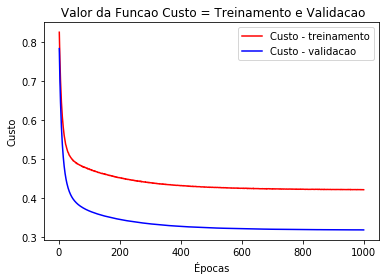

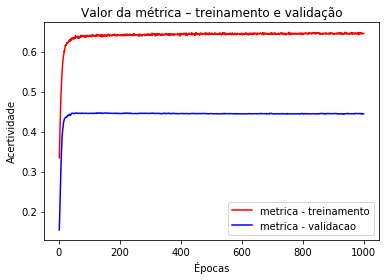

In [62]:
rna6.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna6.plot()

Confusion matrix, without normalization
[[16248  1689]
 [  873  1190]]


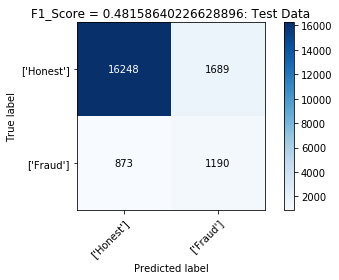

Confusion matrix, without normalization
[[16272  1710]
 [  788  1230]]


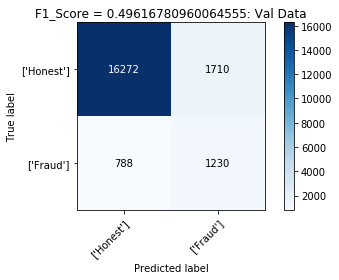

Confusion matrix, without normalization
[[40882  4093]
 [ 8071 12027]]


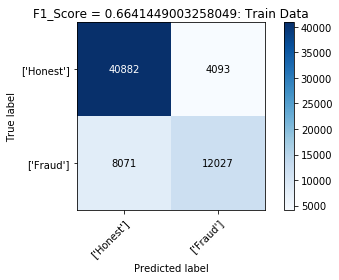

In [63]:
rna6.predict(x_data,y_data)

In [64]:
n_list7 = [50,1]
activation_list7 = ['tanh','sigmoid']
dropout_list7 = [0.2]

In [65]:
rna7 = new_rna_droplist()
rna7.build_model(data_shape,n_list7,activation_list7,dropout_list7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.7960 - f1: 0.3801 - val_loss: 0.7634 - val_f1: 0.1874
Epoch 2/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.7638 - f1: 0.4036 - val_loss: 0.7264 - val_f1: 0.2153
Epoch 3/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.7362 - f1: 0.4341 - val_loss: 0.6942 - val_f1: 0.2421
Epoch 4/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.7125 - f1: 0.4615 - val_loss: 0.6659 - val_f1: 0.2732
Epoch 5/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.6909 - f1: 0.4851 - val_loss: 0.6410 - val_f1: 0.2979
Epoch 6/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.6724 - f1: 0.5045 - val_loss: 0.6191 - val_f1: 0.3219
Epoch 7/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.6559 - f1: 0.5271 - val_loss: 0.5995 - val_f1

65073/65073 [==============================] - 3s 47us/step - loss: 0.4885 - f1: 0.6361 - val_loss: 0.3863 - val_f1: 0.4450
Epoch 61/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4882 - f1: 0.6352 - val_loss: 0.3856 - val_f1: 0.4451
Epoch 62/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4881 - f1: 0.6362 - val_loss: 0.3849 - val_f1: 0.4459
Epoch 63/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4874 - f1: 0.6361 - val_loss: 0.3842 - val_f1: 0.4455
Epoch 64/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4869 - f1: 0.6368 - val_loss: 0.3836 - val_f1: 0.4457
Epoch 65/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4865 - f1: 0.6374 - val_loss: 0.3829 - val_f1: 0.4460
Epoch 66/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4867 - f1: 0.6355 - val_loss: 0.3823 - val_f1: 0.4460
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 45us/step - loss: 0.4555 - f1: 0.6396 - val_loss: 0.3486 - val_f1: 0.4471
Epoch 179/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4559 - f1: 0.6384 - val_loss: 0.3484 - val_f1: 0.4468
Epoch 180/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4560 - f1: 0.6396 - val_loss: 0.3482 - val_f1: 0.4471
Epoch 181/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4549 - f1: 0.6399 - val_loss: 0.3481 - val_f1: 0.4471
Epoch 182/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4551 - f1: 0.6396 - val_loss: 0.3479 - val_f1: 0.4471
Epoch 183/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4549 - f1: 0.6412 - val_loss: 0.3478 - val_f1: 0.4470
Epoch 184/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4547 - f1: 0.6412 - val_loss: 0.3476 - val_f1: 0.4471
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4466 - f1: 0.6428 - val_loss: 0.3401 - val_f1: 0.4462
Epoch 238/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4461 - f1: 0.6423 - val_loss: 0.3400 - val_f1: 0.4462
Epoch 239/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.4466 - f1: 0.6422 - val_loss: 0.3398 - val_f1: 0.4463
Epoch 240/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4460 - f1: 0.6424 - val_loss: 0.3397 - val_f1: 0.4464
Epoch 241/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4454 - f1: 0.6412 - val_loss: 0.3396 - val_f1: 0.4465
Epoch 242/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4464 - f1: 0.6407 - val_loss: 0.3395 - val_f1: 0.4468
Epoch 243/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4460 - f1: 0.6426 - val_loss: 0.3394 - val_f1: 0.4468
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 51us/step - loss: 0.4397 - f1: 0.6425 - val_loss: 0.3339 - val_f1: 0.4460
Epoch 297/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4398 - f1: 0.6395 - val_loss: 0.3338 - val_f1: 0.4457
Epoch 298/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4399 - f1: 0.6434 - val_loss: 0.3338 - val_f1: 0.4456
Epoch 299/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4397 - f1: 0.6398 - val_loss: 0.3337 - val_f1: 0.4457
Epoch 300/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4392 - f1: 0.6437 - val_loss: 0.3336 - val_f1: 0.4455
Epoch 301/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4394 - f1: 0.6395 - val_loss: 0.3335 - val_f1: 0.4457
Epoch 302/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4396 - f1: 0.6413 - val_loss: 0.3334 - val_f1: 0.4457
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 48us/step - loss: 0.4351 - f1: 0.6436 - val_loss: 0.3297 - val_f1: 0.4453
Epoch 356/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4347 - f1: 0.6421 - val_loss: 0.3296 - val_f1: 0.4453
Epoch 357/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4345 - f1: 0.6425 - val_loss: 0.3295 - val_f1: 0.4452
Epoch 358/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4344 - f1: 0.6438 - val_loss: 0.3294 - val_f1: 0.4451
Epoch 359/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4347 - f1: 0.6440 - val_loss: 0.3294 - val_f1: 0.4452
Epoch 360/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4350 - f1: 0.6440 - val_loss: 0.3293 - val_f1: 0.4452
Epoch 361/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4339 - f1: 0.6425 - val_loss: 0.3293 - val_f1: 0.4451
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 48us/step - loss: 0.4310 - f1: 0.6425 - val_loss: 0.3265 - val_f1: 0.4449
Epoch 415/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4312 - f1: 0.6428 - val_loss: 0.3265 - val_f1: 0.4448
Epoch 416/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4312 - f1: 0.6446 - val_loss: 0.3264 - val_f1: 0.4449
Epoch 417/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4306 - f1: 0.6427 - val_loss: 0.3264 - val_f1: 0.4449
Epoch 418/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4309 - f1: 0.6432 - val_loss: 0.3263 - val_f1: 0.4450
Epoch 419/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4309 - f1: 0.6442 - val_loss: 0.3263 - val_f1: 0.4450
Epoch 420/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4310 - f1: 0.6437 - val_loss: 0.3263 - val_f1: 0.4448
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 49us/step - loss: 0.4284 - f1: 0.6430 - val_loss: 0.3242 - val_f1: 0.4447
Epoch 474/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4286 - f1: 0.6432 - val_loss: 0.3242 - val_f1: 0.4445
Epoch 475/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4291 - f1: 0.6439 - val_loss: 0.3242 - val_f1: 0.4447
Epoch 476/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4283 - f1: 0.6440 - val_loss: 0.3241 - val_f1: 0.4447
Epoch 477/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4282 - f1: 0.6462 - val_loss: 0.3241 - val_f1: 0.4446
Epoch 478/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4282 - f1: 0.6432 - val_loss: 0.3240 - val_f1: 0.4446
Epoch 479/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4289 - f1: 0.6418 - val_loss: 0.3240 - val_f1: 0.4445
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 48us/step - loss: 0.4269 - f1: 0.6442 - val_loss: 0.3224 - val_f1: 0.4447
Epoch 533/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4267 - f1: 0.6440 - val_loss: 0.3224 - val_f1: 0.4450
Epoch 534/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4268 - f1: 0.6442 - val_loss: 0.3224 - val_f1: 0.4449
Epoch 535/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4264 - f1: 0.6458 - val_loss: 0.3224 - val_f1: 0.4449
Epoch 536/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4267 - f1: 0.6442 - val_loss: 0.3223 - val_f1: 0.4450
Epoch 537/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4266 - f1: 0.6422 - val_loss: 0.3223 - val_f1: 0.4448
Epoch 538/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4267 - f1: 0.6440 - val_loss: 0.3223 - val_f1: 0.4448
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4253 - f1: 0.6439 - val_loss: 0.3212 - val_f1: 0.4445
Epoch 592/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4252 - f1: 0.6452 - val_loss: 0.3212 - val_f1: 0.4445
Epoch 593/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4252 - f1: 0.6439 - val_loss: 0.3212 - val_f1: 0.4445
Epoch 594/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4257 - f1: 0.6440 - val_loss: 0.3212 - val_f1: 0.4449
Epoch 595/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4251 - f1: 0.6430 - val_loss: 0.3212 - val_f1: 0.4449
Epoch 596/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4251 - f1: 0.6458 - val_loss: 0.3211 - val_f1: 0.4445
Epoch 597/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4256 - f1: 0.6451 - val_loss: 0.3211 - val_f1: 0.4444
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4242 - f1: 0.6460 - val_loss: 0.3203 - val_f1: 0.4443
Epoch 651/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4243 - f1: 0.6447 - val_loss: 0.3203 - val_f1: 0.4442
Epoch 652/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4244 - f1: 0.6452 - val_loss: 0.3203 - val_f1: 0.4441
Epoch 653/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4242 - f1: 0.6437 - val_loss: 0.3203 - val_f1: 0.4443
Epoch 654/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4243 - f1: 0.6461 - val_loss: 0.3202 - val_f1: 0.4443
Epoch 655/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4243 - f1: 0.6442 - val_loss: 0.3202 - val_f1: 0.4444
Epoch 656/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4244 - f1: 0.6460 - val_loss: 0.3202 - val_f1: 0.4443
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4233 - f1: 0.6445 - val_loss: 0.3196 - val_f1: 0.4444
Epoch 710/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4235 - f1: 0.6448 - val_loss: 0.3196 - val_f1: 0.4444
Epoch 711/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4233 - f1: 0.6453 - val_loss: 0.3196 - val_f1: 0.4445
Epoch 712/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4235 - f1: 0.6451 - val_loss: 0.3196 - val_f1: 0.4454
Epoch 713/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4233 - f1: 0.6445 - val_loss: 0.3196 - val_f1: 0.4453
Epoch 714/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4232 - f1: 0.6452 - val_loss: 0.3196 - val_f1: 0.4451
Epoch 715/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4233 - f1: 0.6445 - val_loss: 0.3197 - val_f1: 0.4442
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4229 - f1: 0.6454 - val_loss: 0.3191 - val_f1: 0.4444
Epoch 769/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4227 - f1: 0.6445 - val_loss: 0.3191 - val_f1: 0.4445
Epoch 770/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4231 - f1: 0.6439 - val_loss: 0.3191 - val_f1: 0.4444
Epoch 771/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4226 - f1: 0.6440 - val_loss: 0.3190 - val_f1: 0.4445
Epoch 772/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4226 - f1: 0.6464 - val_loss: 0.3190 - val_f1: 0.4444
Epoch 773/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4228 - f1: 0.6454 - val_loss: 0.3190 - val_f1: 0.4444
Epoch 774/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4228 - f1: 0.6465 - val_loss: 0.3190 - val_f1: 0.4444
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 46us/step - loss: 0.4226 - f1: 0.6478 - val_loss: 0.3187 - val_f1: 0.4454
Epoch 828/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4225 - f1: 0.6448 - val_loss: 0.3187 - val_f1: 0.4450
Epoch 829/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4227 - f1: 0.6427 - val_loss: 0.3187 - val_f1: 0.4451
Epoch 830/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4227 - f1: 0.6427 - val_loss: 0.3187 - val_f1: 0.4457
Epoch 831/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4224 - f1: 0.6436 - val_loss: 0.3187 - val_f1: 0.4446
Epoch 832/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4225 - f1: 0.6445 - val_loss: 0.3187 - val_f1: 0.4442
Epoch 833/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4221 - f1: 0.6457 - val_loss: 0.3187 - val_f1: 0.4441
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4216 - f1: 0.6462 - val_loss: 0.3184 - val_f1: 0.4445
Epoch 887/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4219 - f1: 0.6461 - val_loss: 0.3184 - val_f1: 0.4446
Epoch 888/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4219 - f1: 0.6460 - val_loss: 0.3184 - val_f1: 0.4446
Epoch 889/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4221 - f1: 0.6465 - val_loss: 0.3184 - val_f1: 0.4443
Epoch 890/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4221 - f1: 0.6466 - val_loss: 0.3184 - val_f1: 0.4445
Epoch 891/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4222 - f1: 0.6456 - val_loss: 0.3184 - val_f1: 0.4448
Epoch 892/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4221 - f1: 0.6453 - val_loss: 0.3184 - val_f1: 0.4443
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4214 - f1: 0.6447 - val_loss: 0.3182 - val_f1: 0.4456
Epoch 946/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4220 - f1: 0.6465 - val_loss: 0.3181 - val_f1: 0.4448
Epoch 947/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4219 - f1: 0.6488 - val_loss: 0.3181 - val_f1: 0.4455
Epoch 948/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4216 - f1: 0.6463 - val_loss: 0.3181 - val_f1: 0.4455
Epoch 949/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4217 - f1: 0.6458 - val_loss: 0.3181 - val_f1: 0.4451
Epoch 950/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4218 - f1: 0.6438 - val_loss: 0.3182 - val_f1: 0.4449
Epoch 951/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4221 - f1: 0.6454 - val_loss: 0.3182 - val_f1: 0.4451
Epoch 952/1000
65073/65073 [==============

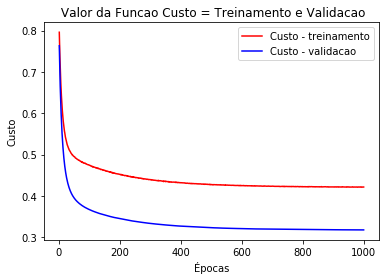

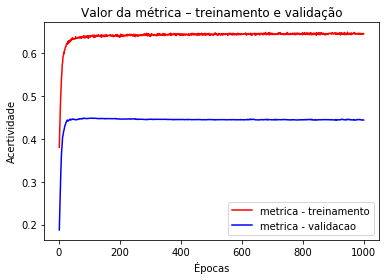

In [66]:
rna7.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna7.plot()

Confusion matrix, without normalization
[[16250  1687]
 [  873  1190]]


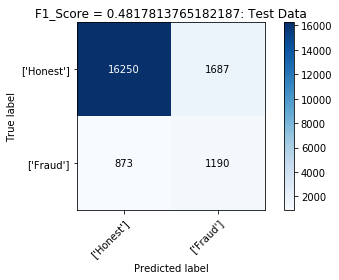

Confusion matrix, without normalization
[[16270  1712]
 [  789  1229]]


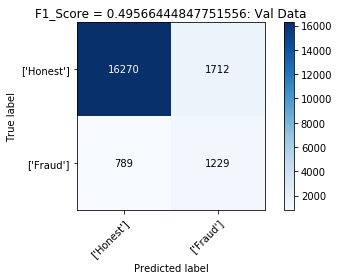

Confusion matrix, without normalization
[[40873  4102]
 [ 8075 12023]]


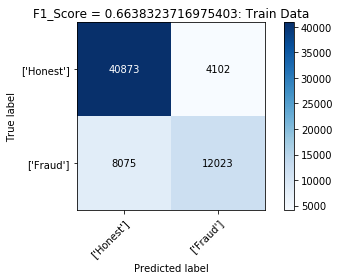

In [67]:
rna7.predict(x_data,y_data)

In [68]:
n_list8 = [50,1]
activation_list8 = ['tanh','sigmoid']
dropout_list8 = [0.2]

In [69]:
rna8 = new_rna_droplist()
rna8.build_model(data_shape,n_list8,activation_list8,dropout_list8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 3s 53us/step - loss: 0.8136 - f1: 0.3518 - val_loss: 0.7791 - val_f1: 0.1553
Epoch 2/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.7832 - f1: 0.3718 - val_loss: 0.7432 - val_f1: 0.1744
Epoch 3/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.7552 - f1: 0.3986 - val_loss: 0.7116 - val_f1: 0.1979
Epoch 4/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.7306 - f1: 0.4218 - val_loss: 0.6836 - val_f1: 0.2254
Epoch 5/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.7096 - f1: 0.4421 - val_loss: 0.6588 - val_f1: 0.2537
Epoch 6/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.6911 - f1: 0.4685 - val_loss: 0.6367 - val_f1: 0.2805
Epoch 7/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.6736 - f1: 0.4856 - val_loss: 0.6168 - val_f1

65073/65073 [==============================] - 3s 45us/step - loss: 0.4897 - f1: 0.6379 - val_loss: 0.3880 - val_f1: 0.4497
Epoch 61/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4889 - f1: 0.6344 - val_loss: 0.3872 - val_f1: 0.4498
Epoch 62/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4885 - f1: 0.6391 - val_loss: 0.3865 - val_f1: 0.4489
Epoch 63/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4886 - f1: 0.6359 - val_loss: 0.3857 - val_f1: 0.4484
Epoch 64/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4878 - f1: 0.6363 - val_loss: 0.3851 - val_f1: 0.4489
Epoch 65/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4873 - f1: 0.6383 - val_loss: 0.3844 - val_f1: 0.4491
Epoch 66/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4875 - f1: 0.6363 - val_loss: 0.3837 - val_f1: 0.4498
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 3s 44us/step - loss: 0.4564 - f1: 0.6419 - val_loss: 0.3490 - val_f1: 0.4468
Epoch 179/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4562 - f1: 0.6370 - val_loss: 0.3488 - val_f1: 0.4468
Epoch 180/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4565 - f1: 0.6405 - val_loss: 0.3486 - val_f1: 0.4468
Epoch 181/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4555 - f1: 0.6430 - val_loss: 0.3485 - val_f1: 0.4467
Epoch 182/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4561 - f1: 0.6426 - val_loss: 0.3483 - val_f1: 0.4467
Epoch 183/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4556 - f1: 0.6398 - val_loss: 0.3481 - val_f1: 0.4467
Epoch 184/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4557 - f1: 0.6398 - val_loss: 0.3479 - val_f1: 0.4469
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4468 - f1: 0.6413 - val_loss: 0.3404 - val_f1: 0.4453
Epoch 238/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4466 - f1: 0.6423 - val_loss: 0.3402 - val_f1: 0.4454
Epoch 239/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4467 - f1: 0.6411 - val_loss: 0.3401 - val_f1: 0.4452
Epoch 240/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4466 - f1: 0.6419 - val_loss: 0.3400 - val_f1: 0.4451
Epoch 241/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4460 - f1: 0.6440 - val_loss: 0.3399 - val_f1: 0.4452
Epoch 242/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4463 - f1: 0.6432 - val_loss: 0.3397 - val_f1: 0.4452
Epoch 243/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4461 - f1: 0.6411 - val_loss: 0.3396 - val_f1: 0.4454
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4401 - f1: 0.6426 - val_loss: 0.3343 - val_f1: 0.4466
Epoch 297/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4403 - f1: 0.6445 - val_loss: 0.3342 - val_f1: 0.4464
Epoch 298/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4399 - f1: 0.6405 - val_loss: 0.3341 - val_f1: 0.4465
Epoch 299/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4397 - f1: 0.6427 - val_loss: 0.3340 - val_f1: 0.4464
Epoch 300/1000
65073/65073 [==============================] - 3s 49us/step - loss: 0.4393 - f1: 0.6445 - val_loss: 0.3339 - val_f1: 0.4465
Epoch 301/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4394 - f1: 0.6432 - val_loss: 0.3339 - val_f1: 0.4459
Epoch 302/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4398 - f1: 0.6425 - val_loss: 0.3338 - val_f1: 0.4459
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4352 - f1: 0.6417 - val_loss: 0.3299 - val_f1: 0.4452
Epoch 356/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4356 - f1: 0.6396 - val_loss: 0.3298 - val_f1: 0.4452
Epoch 357/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4344 - f1: 0.6458 - val_loss: 0.3297 - val_f1: 0.4453
Epoch 358/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4347 - f1: 0.6428 - val_loss: 0.3297 - val_f1: 0.4454
Epoch 359/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4351 - f1: 0.6437 - val_loss: 0.3296 - val_f1: 0.4450
Epoch 360/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4352 - f1: 0.6437 - val_loss: 0.3295 - val_f1: 0.4450
Epoch 361/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4349 - f1: 0.6423 - val_loss: 0.3294 - val_f1: 0.4449
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4314 - f1: 0.6431 - val_loss: 0.3267 - val_f1: 0.4456
Epoch 415/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4312 - f1: 0.6434 - val_loss: 0.3266 - val_f1: 0.4452
Epoch 416/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4312 - f1: 0.6444 - val_loss: 0.3266 - val_f1: 0.4452
Epoch 417/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4314 - f1: 0.6444 - val_loss: 0.3265 - val_f1: 0.4453
Epoch 418/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4312 - f1: 0.6454 - val_loss: 0.3265 - val_f1: 0.4450
Epoch 419/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4312 - f1: 0.6456 - val_loss: 0.3265 - val_f1: 0.4452
Epoch 420/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4312 - f1: 0.6442 - val_loss: 0.3264 - val_f1: 0.4451
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4287 - f1: 0.6460 - val_loss: 0.3244 - val_f1: 0.4451
Epoch 474/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4292 - f1: 0.6456 - val_loss: 0.3243 - val_f1: 0.4452
Epoch 475/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4291 - f1: 0.6437 - val_loss: 0.3243 - val_f1: 0.4452
Epoch 476/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4290 - f1: 0.6426 - val_loss: 0.3243 - val_f1: 0.4451
Epoch 477/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4288 - f1: 0.6436 - val_loss: 0.3242 - val_f1: 0.4450
Epoch 478/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4288 - f1: 0.6431 - val_loss: 0.3242 - val_f1: 0.4454
Epoch 479/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4290 - f1: 0.6457 - val_loss: 0.3241 - val_f1: 0.4457
Epoch 480/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4268 - f1: 0.6472 - val_loss: 0.3226 - val_f1: 0.4449
Epoch 533/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4268 - f1: 0.6448 - val_loss: 0.3226 - val_f1: 0.4453
Epoch 534/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4270 - f1: 0.6416 - val_loss: 0.3226 - val_f1: 0.4454
Epoch 535/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4272 - f1: 0.6446 - val_loss: 0.3226 - val_f1: 0.4452
Epoch 536/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4269 - f1: 0.6424 - val_loss: 0.3225 - val_f1: 0.4454
Epoch 537/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4268 - f1: 0.6438 - val_loss: 0.3225 - val_f1: 0.4446
Epoch 538/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4268 - f1: 0.6449 - val_loss: 0.3225 - val_f1: 0.4449
Epoch 539/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4255 - f1: 0.6451 - val_loss: 0.3213 - val_f1: 0.4450
Epoch 592/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4256 - f1: 0.6465 - val_loss: 0.3213 - val_f1: 0.4448
Epoch 593/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4254 - f1: 0.6431 - val_loss: 0.3213 - val_f1: 0.4448
Epoch 594/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4256 - f1: 0.6459 - val_loss: 0.3213 - val_f1: 0.4447
Epoch 595/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4255 - f1: 0.6440 - val_loss: 0.3213 - val_f1: 0.4449
Epoch 596/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4255 - f1: 0.6411 - val_loss: 0.3213 - val_f1: 0.4448
Epoch 597/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4251 - f1: 0.6443 - val_loss: 0.3213 - val_f1: 0.4451
Epoch 598/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4244 - f1: 0.6437 - val_loss: 0.3204 - val_f1: 0.4442
Epoch 651/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4245 - f1: 0.6442 - val_loss: 0.3205 - val_f1: 0.4445
Epoch 652/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4244 - f1: 0.6441 - val_loss: 0.3204 - val_f1: 0.4446
Epoch 653/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4248 - f1: 0.6427 - val_loss: 0.3204 - val_f1: 0.4446
Epoch 654/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4243 - f1: 0.6449 - val_loss: 0.3204 - val_f1: 0.4446
Epoch 655/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4243 - f1: 0.6451 - val_loss: 0.3204 - val_f1: 0.4447
Epoch 656/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4244 - f1: 0.6446 - val_loss: 0.3204 - val_f1: 0.4446
Epoch 657/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4235 - f1: 0.6462 - val_loss: 0.3198 - val_f1: 0.4458
Epoch 710/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4236 - f1: 0.6454 - val_loss: 0.3198 - val_f1: 0.4459
Epoch 711/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4240 - f1: 0.6453 - val_loss: 0.3198 - val_f1: 0.4456
Epoch 712/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4238 - f1: 0.6443 - val_loss: 0.3198 - val_f1: 0.4456
Epoch 713/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4235 - f1: 0.6449 - val_loss: 0.3197 - val_f1: 0.4445
Epoch 714/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4237 - f1: 0.6438 - val_loss: 0.3197 - val_f1: 0.4447
Epoch 715/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4235 - f1: 0.6473 - val_loss: 0.3197 - val_f1: 0.4452
Epoch 716/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4229 - f1: 0.6450 - val_loss: 0.3192 - val_f1: 0.4443
Epoch 769/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4231 - f1: 0.6435 - val_loss: 0.3193 - val_f1: 0.4444
Epoch 770/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4228 - f1: 0.6460 - val_loss: 0.3192 - val_f1: 0.4444
Epoch 771/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4231 - f1: 0.6438 - val_loss: 0.3192 - val_f1: 0.4444
Epoch 772/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4229 - f1: 0.6456 - val_loss: 0.3192 - val_f1: 0.4444
Epoch 773/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4231 - f1: 0.6463 - val_loss: 0.3192 - val_f1: 0.4443
Epoch 774/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4231 - f1: 0.6460 - val_loss: 0.3192 - val_f1: 0.4446
Epoch 775/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 44us/step - loss: 0.4226 - f1: 0.6437 - val_loss: 0.3188 - val_f1: 0.4444
Epoch 828/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4226 - f1: 0.6430 - val_loss: 0.3188 - val_f1: 0.4441
Epoch 829/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4223 - f1: 0.6457 - val_loss: 0.3188 - val_f1: 0.4440
Epoch 830/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4226 - f1: 0.6462 - val_loss: 0.3188 - val_f1: 0.4440
Epoch 831/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4224 - f1: 0.6467 - val_loss: 0.3188 - val_f1: 0.4441
Epoch 832/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4223 - f1: 0.6451 - val_loss: 0.3188 - val_f1: 0.4441
Epoch 833/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4225 - f1: 0.6463 - val_loss: 0.3188 - val_f1: 0.4440
Epoch 834/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4222 - f1: 0.6446 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 887/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4219 - f1: 0.6446 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 888/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4224 - f1: 0.6446 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 889/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4222 - f1: 0.6449 - val_loss: 0.3185 - val_f1: 0.4446
Epoch 890/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4220 - f1: 0.6454 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 891/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4223 - f1: 0.6458 - val_loss: 0.3185 - val_f1: 0.4446
Epoch 892/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4222 - f1: 0.6462 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 893/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 45us/step - loss: 0.4217 - f1: 0.6441 - val_loss: 0.3182 - val_f1: 0.4446
Epoch 946/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4217 - f1: 0.6443 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 947/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4216 - f1: 0.6458 - val_loss: 0.3182 - val_f1: 0.4446
Epoch 948/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4221 - f1: 0.6450 - val_loss: 0.3182 - val_f1: 0.4452
Epoch 949/1000
65073/65073 [==============================] - 3s 47us/step - loss: 0.4221 - f1: 0.6469 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 950/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4218 - f1: 0.6470 - val_loss: 0.3182 - val_f1: 0.4443
Epoch 951/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4219 - f1: 0.6452 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 952/1000
65073/65073 [==============

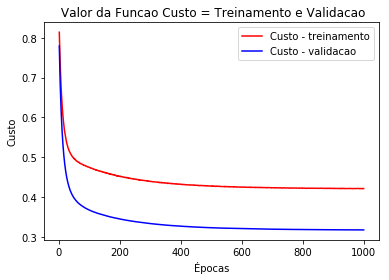

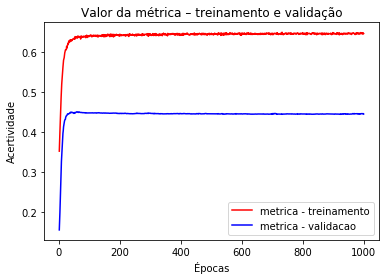

In [ ]:
rna8.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna8.plot()

Confusion matrix, without normalization
[[16251  1686]
 [  874  1189]]


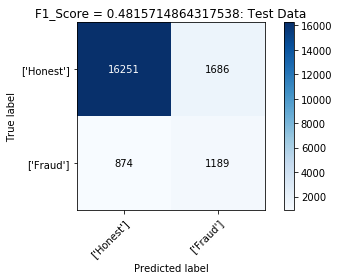

Confusion matrix, without normalization
[[16275  1707]
 [  788  1230]]


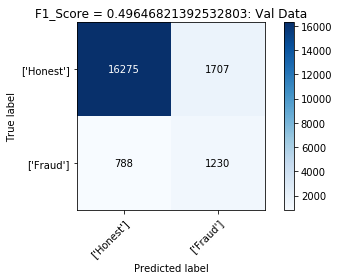

Confusion matrix, without normalization
[[40883  4092]
 [ 8072 12026]]


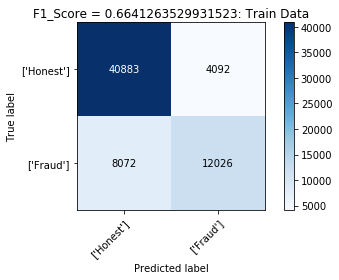

In [ ]:
rna8.predict(x_data,y_data)

In [21]:
n_list9 = [50,1]
activation_list9 = ['tanh','sigmoid']
dropout_list9 = [0.2]

In [22]:
rna9 = new_rna_droplist()
rna9.build_model(data_shape,n_list9,activation_list9,dropout_list9)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 6s 95us/step - loss: 0.7976 - f1: 0.3742 - val_loss: 0.7657 - val_f1: 0.1754
Epoch 2/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.7679 - f1: 0.3992 - val_loss: 0.7311 - val_f1: 0.1984
Epoch 3/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.7414 - f1: 0.4244 - val_loss: 0.7005 - val_f1: 0.2219
Epoch 4/1000
65073/65073 [==============================] - 5s 81us/step - loss: 0.7185 - f1: 0.4509 - val_loss: 0.6735 - val_f1: 0.2527
Epoch 5/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.6986 - f1: 0.4736 - val_loss: 0.6495 - val_f1: 0.2818
Epoch 6/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.6807 - f1: 0.4922 - val_loss: 0.6280 - val_f1: 0.3069
Epoch 7/1000
65073/65073 [==============================] - 5s 83us/step - loss:

65073/65073 [==============================] - 5s 75us/step - loss: 0.4902 - f1: 0.6356 - val_loss: 0.3892 - val_f1: 0.4446
Epoch 59/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4900 - f1: 0.6356 - val_loss: 0.3884 - val_f1: 0.4447
Epoch 60/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4900 - f1: 0.6320 - val_loss: 0.3876 - val_f1: 0.4440
Epoch 61/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4885 - f1: 0.6360 - val_loss: 0.3868 - val_f1: 0.4431
Epoch 62/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4882 - f1: 0.6365 - val_loss: 0.3861 - val_f1: 0.4437
Epoch 63/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4873 - f1: 0.6376 - val_loss: 0.3854 - val_f1: 0.4432
Epoch 64/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4877 - f1: 0.6328 - val_loss: 0.3847 - val_f1: 0.4441
Epoch 65/1000
65073/65073 [=====================

65073/65073 [==============================] - 5s 75us/step - loss: 0.4693 - f1: 0.6422 - val_loss: 0.3623 - val_f1: 0.4462
Epoch 118/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4691 - f1: 0.6409 - val_loss: 0.3621 - val_f1: 0.4462
Epoch 119/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4691 - f1: 0.6381 - val_loss: 0.3618 - val_f1: 0.4461
Epoch 120/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4687 - f1: 0.6401 - val_loss: 0.3615 - val_f1: 0.4461
Epoch 121/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4691 - f1: 0.6406 - val_loss: 0.3612 - val_f1: 0.4461
Epoch 122/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4687 - f1: 0.6396 - val_loss: 0.3609 - val_f1: 0.4462
Epoch 123/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4679 - f1: 0.6384 - val_loss: 0.3607 - val_f1: 0.4461
Epoch 124/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 75us/step - loss: 0.4560 - f1: 0.6426 - val_loss: 0.3493 - val_f1: 0.4468
Epoch 177/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4562 - f1: 0.6418 - val_loss: 0.3491 - val_f1: 0.4464
Epoch 178/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4565 - f1: 0.6402 - val_loss: 0.3489 - val_f1: 0.4468
Epoch 179/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4552 - f1: 0.6415 - val_loss: 0.3487 - val_f1: 0.4468
Epoch 180/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4555 - f1: 0.6426 - val_loss: 0.3486 - val_f1: 0.4468
Epoch 181/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4558 - f1: 0.6394 - val_loss: 0.3484 - val_f1: 0.4464
Epoch 182/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4557 - f1: 0.6400 - val_loss: 0.3482 - val_f1: 0.4462
Epoch 183/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 76us/step - loss: 0.4470 - f1: 0.6433 - val_loss: 0.3405 - val_f1: 0.4461
Epoch 236/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4469 - f1: 0.6420 - val_loss: 0.3404 - val_f1: 0.4462
Epoch 237/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4470 - f1: 0.6397 - val_loss: 0.3403 - val_f1: 0.4461
Epoch 238/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4469 - f1: 0.6395 - val_loss: 0.3401 - val_f1: 0.4459
Epoch 239/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4466 - f1: 0.6417 - val_loss: 0.3400 - val_f1: 0.4464
Epoch 240/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4464 - f1: 0.6418 - val_loss: 0.3399 - val_f1: 0.4463
Epoch 241/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4468 - f1: 0.6408 - val_loss: 0.3398 - val_f1: 0.4463
Epoch 242/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 75us/step - loss: 0.4404 - f1: 0.6420 - val_loss: 0.3344 - val_f1: 0.4455
Epoch 295/1000
65073/65073 [==============================] - 5s 82us/step - loss: 0.4398 - f1: 0.6466 - val_loss: 0.3343 - val_f1: 0.4455
Epoch 296/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4400 - f1: 0.6441 - val_loss: 0.3342 - val_f1: 0.4455
Epoch 297/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4403 - f1: 0.6413 - val_loss: 0.3341 - val_f1: 0.4455
Epoch 298/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4403 - f1: 0.6417 - val_loss: 0.3341 - val_f1: 0.4458
Epoch 299/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4394 - f1: 0.6424 - val_loss: 0.3340 - val_f1: 0.4458
Epoch 300/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4397 - f1: 0.6445 - val_loss: 0.3339 - val_f1: 0.4458
Epoch 301/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 75us/step - loss: 0.4355 - f1: 0.6420 - val_loss: 0.3300 - val_f1: 0.4452
Epoch 354/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4354 - f1: 0.6415 - val_loss: 0.3299 - val_f1: 0.4452
Epoch 355/1000
65073/65073 [==============================] - 5s 81us/step - loss: 0.4351 - f1: 0.6435 - val_loss: 0.3298 - val_f1: 0.4452
Epoch 356/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4350 - f1: 0.6425 - val_loss: 0.3298 - val_f1: 0.4455
Epoch 357/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4346 - f1: 0.6448 - val_loss: 0.3297 - val_f1: 0.4455
Epoch 358/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4352 - f1: 0.6423 - val_loss: 0.3296 - val_f1: 0.4455
Epoch 359/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4346 - f1: 0.6452 - val_loss: 0.3296 - val_f1: 0.4453
Epoch 360/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 81us/step - loss: 0.4317 - f1: 0.6437 - val_loss: 0.3267 - val_f1: 0.4456
Epoch 413/1000
65073/65073 [==============================] - 5s 73us/step - loss: 0.4316 - f1: 0.6411 - val_loss: 0.3266 - val_f1: 0.4455
Epoch 414/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4313 - f1: 0.6436 - val_loss: 0.3266 - val_f1: 0.4456
Epoch 415/1000
65073/65073 [==============================] - 5s 82us/step - loss: 0.4314 - f1: 0.6424 - val_loss: 0.3266 - val_f1: 0.4454
Epoch 416/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4315 - f1: 0.6442 - val_loss: 0.3265 - val_f1: 0.4454
Epoch 417/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4311 - f1: 0.6445 - val_loss: 0.3264 - val_f1: 0.4454
Epoch 418/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4312 - f1: 0.6436 - val_loss: 0.3264 - val_f1: 0.4454
Epoch 419/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 74us/step - loss: 0.4291 - f1: 0.6445 - val_loss: 0.3244 - val_f1: 0.4451
Epoch 472/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4287 - f1: 0.6443 - val_loss: 0.3243 - val_f1: 0.4451
Epoch 473/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4287 - f1: 0.6477 - val_loss: 0.3243 - val_f1: 0.4450
Epoch 474/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4290 - f1: 0.6464 - val_loss: 0.3242 - val_f1: 0.4446
Epoch 475/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4285 - f1: 0.6444 - val_loss: 0.3242 - val_f1: 0.4451
Epoch 476/1000
65073/65073 [==============================] - 5s 81us/step - loss: 0.4289 - f1: 0.6451 - val_loss: 0.3241 - val_f1: 0.4450
Epoch 477/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4284 - f1: 0.6425 - val_loss: 0.3241 - val_f1: 0.4448
Epoch 478/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 79us/step - loss: 0.4271 - f1: 0.6452 - val_loss: 0.3227 - val_f1: 0.4454
Epoch 531/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4267 - f1: 0.6431 - val_loss: 0.3226 - val_f1: 0.4452
Epoch 532/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4272 - f1: 0.6454 - val_loss: 0.3226 - val_f1: 0.4452
Epoch 533/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4271 - f1: 0.6434 - val_loss: 0.3226 - val_f1: 0.4453
Epoch 534/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4266 - f1: 0.6465 - val_loss: 0.3225 - val_f1: 0.4452
Epoch 535/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4268 - f1: 0.6466 - val_loss: 0.3225 - val_f1: 0.4450
Epoch 536/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4272 - f1: 0.6426 - val_loss: 0.3225 - val_f1: 0.4449
Epoch 537/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 75us/step - loss: 0.4259 - f1: 0.6460 - val_loss: 0.3214 - val_f1: 0.4448
Epoch 590/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4258 - f1: 0.6436 - val_loss: 0.3214 - val_f1: 0.4449
Epoch 591/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4253 - f1: 0.6482 - val_loss: 0.3214 - val_f1: 0.4450
Epoch 592/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4253 - f1: 0.6451 - val_loss: 0.3214 - val_f1: 0.4449
Epoch 593/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4254 - f1: 0.6436 - val_loss: 0.3214 - val_f1: 0.4449
Epoch 594/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4256 - f1: 0.6457 - val_loss: 0.3213 - val_f1: 0.4449
Epoch 595/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4249 - f1: 0.6456 - val_loss: 0.3213 - val_f1: 0.4448
Epoch 596/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 80us/step - loss: 0.4247 - f1: 0.6436 - val_loss: 0.3204 - val_f1: 0.4445
Epoch 649/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4241 - f1: 0.6474 - val_loss: 0.3204 - val_f1: 0.4444
Epoch 650/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4246 - f1: 0.6452 - val_loss: 0.3204 - val_f1: 0.4447
Epoch 651/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4243 - f1: 0.6468 - val_loss: 0.3204 - val_f1: 0.4447
Epoch 652/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4244 - f1: 0.6441 - val_loss: 0.3204 - val_f1: 0.4451
Epoch 653/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4243 - f1: 0.6459 - val_loss: 0.3204 - val_f1: 0.4448
Epoch 654/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4240 - f1: 0.6436 - val_loss: 0.3203 - val_f1: 0.4449
Epoch 655/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 74us/step - loss: 0.4238 - f1: 0.6460 - val_loss: 0.3198 - val_f1: 0.4443
Epoch 708/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4236 - f1: 0.6461 - val_loss: 0.3198 - val_f1: 0.4442
Epoch 709/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4235 - f1: 0.6452 - val_loss: 0.3198 - val_f1: 0.4443
Epoch 710/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4236 - f1: 0.6458 - val_loss: 0.3197 - val_f1: 0.4443
Epoch 711/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4237 - f1: 0.6458 - val_loss: 0.3197 - val_f1: 0.4446
Epoch 712/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4234 - f1: 0.6458 - val_loss: 0.3197 - val_f1: 0.4443
Epoch 713/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4236 - f1: 0.6459 - val_loss: 0.3197 - val_f1: 0.4446
Epoch 714/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 77us/step - loss: 0.4228 - f1: 0.6463 - val_loss: 0.3193 - val_f1: 0.4452
Epoch 767/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4228 - f1: 0.6459 - val_loss: 0.3193 - val_f1: 0.4452
Epoch 768/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4225 - f1: 0.6447 - val_loss: 0.3193 - val_f1: 0.4449
Epoch 769/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4228 - f1: 0.6464 - val_loss: 0.3192 - val_f1: 0.4452
Epoch 770/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4230 - f1: 0.6467 - val_loss: 0.3193 - val_f1: 0.4450
Epoch 771/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4228 - f1: 0.6443 - val_loss: 0.3192 - val_f1: 0.4450
Epoch 772/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4227 - f1: 0.6440 - val_loss: 0.3192 - val_f1: 0.4449
Epoch 773/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 79us/step - loss: 0.4225 - f1: 0.6463 - val_loss: 0.3188 - val_f1: 0.4445
Epoch 826/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4224 - f1: 0.6449 - val_loss: 0.3188 - val_f1: 0.4445
Epoch 827/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4223 - f1: 0.6471 - val_loss: 0.3188 - val_f1: 0.4445
Epoch 828/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4223 - f1: 0.6432 - val_loss: 0.3188 - val_f1: 0.4445
Epoch 829/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4223 - f1: 0.6455 - val_loss: 0.3187 - val_f1: 0.4446
Epoch 830/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4226 - f1: 0.6465 - val_loss: 0.3187 - val_f1: 0.4445
Epoch 831/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4223 - f1: 0.6451 - val_loss: 0.3188 - val_f1: 0.4446
Epoch 832/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 74us/step - loss: 0.4225 - f1: 0.6455 - val_loss: 0.3185 - val_f1: 0.4456
Epoch 885/1000
65073/65073 [==============================] - 5s 73us/step - loss: 0.4221 - f1: 0.6436 - val_loss: 0.3185 - val_f1: 0.4449
Epoch 886/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4219 - f1: 0.6439 - val_loss: 0.3185 - val_f1: 0.4455
Epoch 887/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4220 - f1: 0.6448 - val_loss: 0.3185 - val_f1: 0.4448
Epoch 888/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4221 - f1: 0.6441 - val_loss: 0.3184 - val_f1: 0.4448
Epoch 889/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4222 - f1: 0.6449 - val_loss: 0.3184 - val_f1: 0.4447
Epoch 890/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4220 - f1: 0.6454 - val_loss: 0.3185 - val_f1: 0.4447
Epoch 891/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 79us/step - loss: 0.4217 - f1: 0.6446 - val_loss: 0.3182 - val_f1: 0.4437
Epoch 944/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4215 - f1: 0.6473 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 945/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4221 - f1: 0.6453 - val_loss: 0.3181 - val_f1: 0.4440
Epoch 946/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4217 - f1: 0.6447 - val_loss: 0.3182 - val_f1: 0.4441
Epoch 947/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4217 - f1: 0.6447 - val_loss: 0.3181 - val_f1: 0.4442
Epoch 948/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4214 - f1: 0.6452 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 949/1000
65073/65073 [==============================] - 5s 76us/step - loss: 0.4218 - f1: 0.6463 - val_loss: 0.3182 - val_f1: 0.4452
Epoch 950/1000
65073/65073 [==============

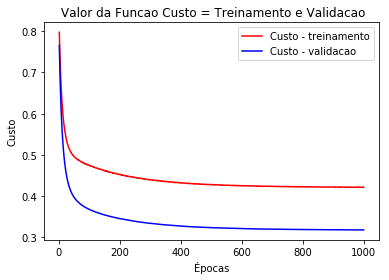

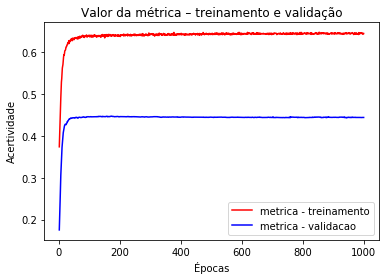

In [23]:
rna9.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna9.plot()

Confusion matrix, without normalization
[[16251  1686]
 [  873  1190]]


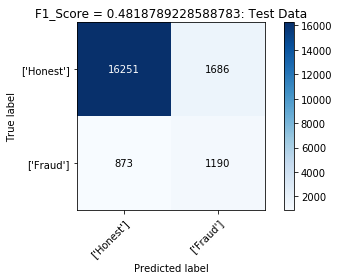

Confusion matrix, without normalization
[[16271  1711]
 [  787  1231]]


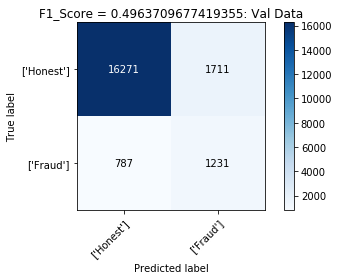

Confusion matrix, without normalization
[[40884  4091]
 [ 8070 12028]]


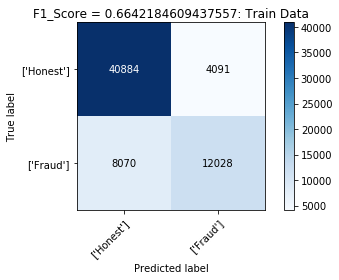

In [24]:
rna9.predict(x_data,y_data)

In [25]:
n_list10 = [50,1]
activation_list10 = ['tanh','sigmoid']
dropout_list10 = [0.2]

In [26]:
rna10 = new_rna_droplist()
rna10.build_model(data_shape,n_list10,activation_list10,dropout_list10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Train on 65073 samples, validate on 20000 samples
Epoch 1/1000
65073/65073 [==============================] - 5s 84us/step - loss: 0.7878 - f1: 0.4010 - val_loss: 0.7559 - val_f1: 0.1952
Epoch 2/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.7541 - f1: 0.4327 - val_loss: 0.7178 - val_f1: 0.2213
Epoch 3/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.7254 - f1: 0.4583 - val_loss: 0.6849 - val_f1: 0.2460
Epoch 4/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.7014 - f1: 0.4827 - val_loss: 0.6562 - val_f1: 0.2763
Epoch 5/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.6792 - f1: 0.5057 - val_loss: 0.6311 - val_f1: 0.3012
Epoch 6/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.6607 - f1: 0.5256 - val_loss: 0.6091 - val_f1: 0.3261
Epoch 7/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.6456 - f1: 0.5401 - val_loss: 0.5896 - val_f1

65073/65073 [==============================] - 5s 74us/step - loss: 0.4875 - f1: 0.6355 - val_loss: 0.3849 - val_f1: 0.4441
Epoch 61/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4875 - f1: 0.6364 - val_loss: 0.3842 - val_f1: 0.4441
Epoch 62/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4870 - f1: 0.6359 - val_loss: 0.3836 - val_f1: 0.4441
Epoch 63/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4863 - f1: 0.6374 - val_loss: 0.3829 - val_f1: 0.4440
Epoch 64/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4859 - f1: 0.6348 - val_loss: 0.3823 - val_f1: 0.4442
Epoch 65/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4859 - f1: 0.6368 - val_loss: 0.3817 - val_f1: 0.4444
Epoch 66/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4851 - f1: 0.6355 - val_loss: 0.3811 - val_f1: 0.4443
Epoch 67/1000
65073/65073 [=====================

65073/65073 [==============================] - 5s 78us/step - loss: 0.4684 - f1: 0.6397 - val_loss: 0.3607 - val_f1: 0.4465
Epoch 120/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4684 - f1: 0.6363 - val_loss: 0.3605 - val_f1: 0.4463
Epoch 121/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4683 - f1: 0.6379 - val_loss: 0.3602 - val_f1: 0.4464
Epoch 122/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4675 - f1: 0.6408 - val_loss: 0.3599 - val_f1: 0.4462
Epoch 123/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4680 - f1: 0.6388 - val_loss: 0.3597 - val_f1: 0.4462
Epoch 124/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4676 - f1: 0.6426 - val_loss: 0.3594 - val_f1: 0.4461
Epoch 125/1000
65073/65073 [==============================] - 5s 77us/step - loss: 0.4669 - f1: 0.6401 - val_loss: 0.3592 - val_f1: 0.4463
Epoch 126/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 74us/step - loss: 0.4552 - f1: 0.6382 - val_loss: 0.3483 - val_f1: 0.4455
Epoch 179/1000
65073/65073 [==============================] - 5s 74us/step - loss: 0.4555 - f1: 0.6413 - val_loss: 0.3481 - val_f1: 0.4457
Epoch 180/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4557 - f1: 0.6408 - val_loss: 0.3479 - val_f1: 0.4462
Epoch 181/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4549 - f1: 0.6427 - val_loss: 0.3478 - val_f1: 0.4463
Epoch 182/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4548 - f1: 0.6416 - val_loss: 0.3476 - val_f1: 0.4463
Epoch 183/1000
65073/65073 [==============================] - 5s 78us/step - loss: 0.4543 - f1: 0.6404 - val_loss: 0.3474 - val_f1: 0.4462
Epoch 184/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4542 - f1: 0.6406 - val_loss: 0.3473 - val_f1: 0.4459
Epoch 185/1000
65073/65073 [==============

65073/65073 [==============================] - 5s 79us/step - loss: 0.4458 - f1: 0.6433 - val_loss: 0.3398 - val_f1: 0.4450
Epoch 238/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4468 - f1: 0.6404 - val_loss: 0.3396 - val_f1: 0.4451
Epoch 239/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4457 - f1: 0.6409 - val_loss: 0.3395 - val_f1: 0.4451
Epoch 240/1000
65073/65073 [==============================] - 5s 79us/step - loss: 0.4459 - f1: 0.6419 - val_loss: 0.3394 - val_f1: 0.4451
Epoch 241/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4459 - f1: 0.6419 - val_loss: 0.3393 - val_f1: 0.4452
Epoch 242/1000
65073/65073 [==============================] - 5s 75us/step - loss: 0.4457 - f1: 0.6416 - val_loss: 0.3391 - val_f1: 0.4450
Epoch 243/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4460 - f1: 0.6423 - val_loss: 0.3390 - val_f1: 0.4450
Epoch 244/1000
65073/65073 [==============

65073/65073 [==============================] - 6s 86us/step - loss: 0.4392 - f1: 0.6435 - val_loss: 0.3337 - val_f1: 0.4449
Epoch 297/1000
65073/65073 [==============================] - 5s 82us/step - loss: 0.4397 - f1: 0.6421 - val_loss: 0.3336 - val_f1: 0.4449
Epoch 298/1000
65073/65073 [==============================] - 5s 83us/step - loss: 0.4389 - f1: 0.6432 - val_loss: 0.3336 - val_f1: 0.4457
Epoch 299/1000
65073/65073 [==============================] - 6s 86us/step - loss: 0.4390 - f1: 0.6429 - val_loss: 0.3335 - val_f1: 0.4457
Epoch 300/1000
65073/65073 [==============================] - 5s 80us/step - loss: 0.4388 - f1: 0.6439 - val_loss: 0.3334 - val_f1: 0.4452
Epoch 301/1000
65073/65073 [==============================] - 5s 81us/step - loss: 0.4384 - f1: 0.6444 - val_loss: 0.3333 - val_f1: 0.4460
Epoch 302/1000
65073/65073 [==============================] - 6s 85us/step - loss: 0.4388 - f1: 0.6424 - val_loss: 0.3332 - val_f1: 0.4460
Epoch 303/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 49us/step - loss: 0.4346 - f1: 0.6400 - val_loss: 0.3293 - val_f1: 0.4447
Epoch 356/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4349 - f1: 0.6431 - val_loss: 0.3293 - val_f1: 0.4444
Epoch 357/1000
65073/65073 [==============================] - 3s 51us/step - loss: 0.4342 - f1: 0.6437 - val_loss: 0.3293 - val_f1: 0.4446
Epoch 358/1000
65073/65073 [==============================] - 3s 46us/step - loss: 0.4346 - f1: 0.6456 - val_loss: 0.3292 - val_f1: 0.4444
Epoch 359/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4345 - f1: 0.6414 - val_loss: 0.3292 - val_f1: 0.4445
Epoch 360/1000
65073/65073 [==============================] - 3s 48us/step - loss: 0.4345 - f1: 0.6422 - val_loss: 0.3291 - val_f1: 0.4446
Epoch 361/1000
65073/65073 [==============================] - 3s 50us/step - loss: 0.4343 - f1: 0.6433 - val_loss: 0.3290 - val_f1: 0.4447
Epoch 362/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4313 - f1: 0.6443 - val_loss: 0.3262 - val_f1: 0.4450
Epoch 415/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4305 - f1: 0.6446 - val_loss: 0.3262 - val_f1: 0.4449
Epoch 416/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4306 - f1: 0.6442 - val_loss: 0.3261 - val_f1: 0.4451
Epoch 417/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4307 - f1: 0.6426 - val_loss: 0.3261 - val_f1: 0.4450
Epoch 418/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4305 - f1: 0.6415 - val_loss: 0.3261 - val_f1: 0.4449
Epoch 419/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4310 - f1: 0.6456 - val_loss: 0.3260 - val_f1: 0.4451
Epoch 420/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4305 - f1: 0.6448 - val_loss: 0.3260 - val_f1: 0.4451
Epoch 421/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4274 - f1: 0.6443 - val_loss: 0.3232 - val_f1: 0.4448
Epoch 497/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4275 - f1: 0.6464 - val_loss: 0.3232 - val_f1: 0.4446
Epoch 498/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4271 - f1: 0.6451 - val_loss: 0.3232 - val_f1: 0.4446
Epoch 499/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4274 - f1: 0.6463 - val_loss: 0.3232 - val_f1: 0.4449
Epoch 500/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4274 - f1: 0.6441 - val_loss: 0.3232 - val_f1: 0.4448
Epoch 501/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4275 - f1: 0.6434 - val_loss: 0.3231 - val_f1: 0.4449
Epoch 502/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4275 - f1: 0.6431 - val_loss: 0.3231 - val_f1: 0.4447
Epoch 503/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4260 - f1: 0.6441 - val_loss: 0.3218 - val_f1: 0.4449
Epoch 556/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4256 - f1: 0.6456 - val_loss: 0.3218 - val_f1: 0.4448
Epoch 557/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4257 - f1: 0.6449 - val_loss: 0.3218 - val_f1: 0.4447
Epoch 558/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4256 - f1: 0.6426 - val_loss: 0.3217 - val_f1: 0.4448
Epoch 559/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4255 - f1: 0.6423 - val_loss: 0.3217 - val_f1: 0.4451
Epoch 560/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4258 - f1: 0.6457 - val_loss: 0.3217 - val_f1: 0.4452
Epoch 561/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4259 - f1: 0.6449 - val_loss: 0.3217 - val_f1: 0.4458
Epoch 562/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4247 - f1: 0.6470 - val_loss: 0.3207 - val_f1: 0.4444
Epoch 615/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4245 - f1: 0.6447 - val_loss: 0.3207 - val_f1: 0.4444
Epoch 616/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4248 - f1: 0.6463 - val_loss: 0.3207 - val_f1: 0.4444
Epoch 617/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4245 - f1: 0.6454 - val_loss: 0.3207 - val_f1: 0.4444
Epoch 618/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4244 - f1: 0.6463 - val_loss: 0.3207 - val_f1: 0.4444
Epoch 619/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4244 - f1: 0.6444 - val_loss: 0.3206 - val_f1: 0.4443
Epoch 620/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4245 - f1: 0.6449 - val_loss: 0.3206 - val_f1: 0.4446
Epoch 621/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 46us/step - loss: 0.4234 - f1: 0.6454 - val_loss: 0.3200 - val_f1: 0.4442
Epoch 674/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4234 - f1: 0.6443 - val_loss: 0.3199 - val_f1: 0.4444
Epoch 675/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4237 - f1: 0.6444 - val_loss: 0.3199 - val_f1: 0.4444
Epoch 676/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4235 - f1: 0.6437 - val_loss: 0.3199 - val_f1: 0.4443
Epoch 677/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4239 - f1: 0.6441 - val_loss: 0.3199 - val_f1: 0.4442
Epoch 678/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4235 - f1: 0.6457 - val_loss: 0.3199 - val_f1: 0.4444
Epoch 679/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4238 - f1: 0.6445 - val_loss: 0.3199 - val_f1: 0.4442
Epoch 680/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4231 - f1: 0.6444 - val_loss: 0.3193 - val_f1: 0.4442
Epoch 733/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4229 - f1: 0.6441 - val_loss: 0.3193 - val_f1: 0.4438
Epoch 734/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4229 - f1: 0.6471 - val_loss: 0.3193 - val_f1: 0.4444
Epoch 735/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4228 - f1: 0.6434 - val_loss: 0.3193 - val_f1: 0.4441
Epoch 736/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4228 - f1: 0.6458 - val_loss: 0.3193 - val_f1: 0.4442
Epoch 737/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4232 - f1: 0.6467 - val_loss: 0.3192 - val_f1: 0.4442
Epoch 738/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4228 - f1: 0.6461 - val_loss: 0.3192 - val_f1: 0.4446
Epoch 739/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4226 - f1: 0.6458 - val_loss: 0.3188 - val_f1: 0.4451
Epoch 792/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4225 - f1: 0.6454 - val_loss: 0.3189 - val_f1: 0.4447
Epoch 793/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4224 - f1: 0.6451 - val_loss: 0.3188 - val_f1: 0.4446
Epoch 794/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4222 - f1: 0.6447 - val_loss: 0.3188 - val_f1: 0.4444
Epoch 795/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4224 - f1: 0.6424 - val_loss: 0.3188 - val_f1: 0.4445
Epoch 796/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4226 - f1: 0.6458 - val_loss: 0.3188 - val_f1: 0.4448
Epoch 797/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4226 - f1: 0.6461 - val_loss: 0.3188 - val_f1: 0.4446
Epoch 798/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 41us/step - loss: 0.4222 - f1: 0.6448 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 851/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4220 - f1: 0.6450 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 852/1000
65073/65073 [==============================] - 3s 44us/step - loss: 0.4222 - f1: 0.6462 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 853/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4223 - f1: 0.6447 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 854/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4219 - f1: 0.6435 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 855/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4221 - f1: 0.6463 - val_loss: 0.3185 - val_f1: 0.4444
Epoch 856/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4216 - f1: 0.6451 - val_loss: 0.3185 - val_f1: 0.4445
Epoch 857/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4216 - f1: 0.6459 - val_loss: 0.3183 - val_f1: 0.4438
Epoch 910/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4216 - f1: 0.6442 - val_loss: 0.3182 - val_f1: 0.4444
Epoch 911/1000
65073/65073 [==============================] - 3s 41us/step - loss: 0.4217 - f1: 0.6442 - val_loss: 0.3183 - val_f1: 0.4444
Epoch 912/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4215 - f1: 0.6471 - val_loss: 0.3182 - val_f1: 0.4445
Epoch 913/1000
65073/65073 [==============================] - 3s 43us/step - loss: 0.4219 - f1: 0.6451 - val_loss: 0.3182 - val_f1: 0.4443
Epoch 914/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4217 - f1: 0.6428 - val_loss: 0.3182 - val_f1: 0.4446
Epoch 915/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4218 - f1: 0.6435 - val_loss: 0.3182 - val_f1: 0.4443
Epoch 916/1000
65073/65073 [==============

65073/65073 [==============================] - 3s 42us/step - loss: 0.4214 - f1: 0.6444 - val_loss: 0.3180 - val_f1: 0.4444
Epoch 969/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4213 - f1: 0.6482 - val_loss: 0.3180 - val_f1: 0.4444
Epoch 970/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4215 - f1: 0.6453 - val_loss: 0.3180 - val_f1: 0.4444
Epoch 971/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4216 - f1: 0.6449 - val_loss: 0.3180 - val_f1: 0.4441
Epoch 972/1000
65073/65073 [==============================] - 3s 45us/step - loss: 0.4215 - f1: 0.6469 - val_loss: 0.3180 - val_f1: 0.4440
Epoch 973/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4212 - f1: 0.6461 - val_loss: 0.3180 - val_f1: 0.4443
Epoch 974/1000
65073/65073 [==============================] - 3s 42us/step - loss: 0.4213 - f1: 0.6471 - val_loss: 0.3180 - val_f1: 0.4443
Epoch 975/1000
65073/65073 [==============

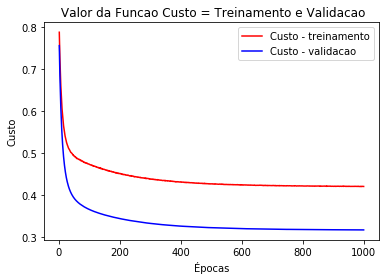

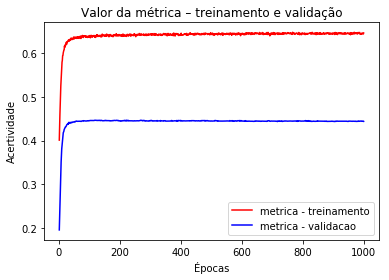

In [27]:
rna10.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna10.plot()

Confusion matrix, without normalization
[[16252  1685]
 [  873  1190]]


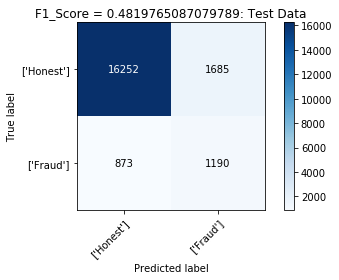

Confusion matrix, without normalization
[[16269  1713]
 [  788  1230]]


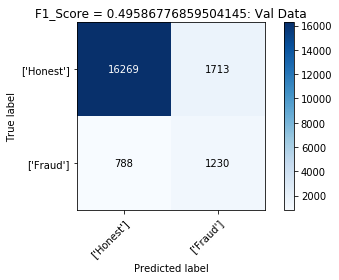

Confusion matrix, without normalization
[[40884  4091]
 [ 8068 12030]]


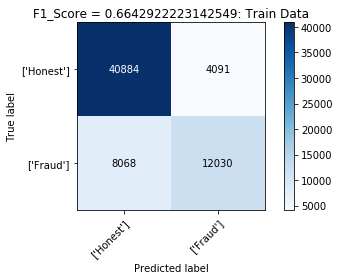

In [28]:
rna10.predict(x_data,y_data)